# Carregando Dados

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, Subset, DataLoader

import copy
import numpy as np
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
CIFAR_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR_STD = [0.2023, 0.1994, 0.2010]

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

# Definindo as transformações
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

# 1. Baixando o conjunto de treino
raw_train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform = None # Pra aplicar data augmentation, precisamos da imagem crua
)

# 2. Baixando o conjunto de teste
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

print(f"Total de imagens de treino: {len(raw_train_dataset)}")
print(f"Total de imagens de teste: {len(test_dataset)}")

100%|██████████| 170M/170M [00:05<00:00, 33.2MB/s]


Total de imagens de treino: 50000
Total de imagens de teste: 10000


Mostrando imagens aleatórias do Conjunto de Treino:


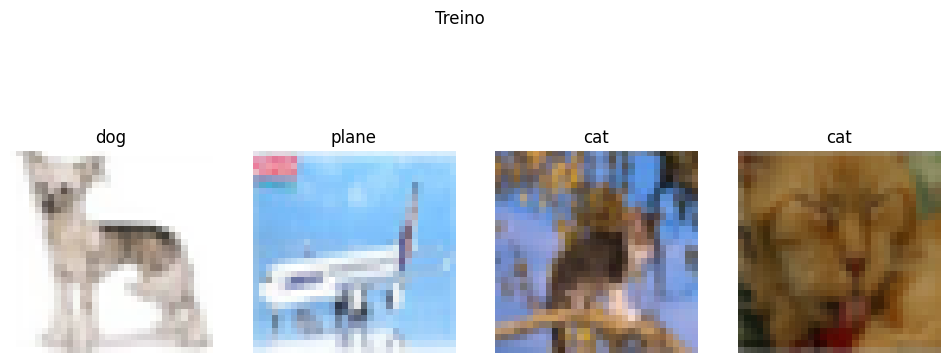

In [ ]:
# ==========================================
#      Funções para Visualizar Dados
# ==========================================

def denormalize(image_tensor):
    """
    Função para visualização de imagens
    """
    img = image_tensor.clone()

    mean = torch.tensor(CIFAR_MEAN).view(3, 1, 1)
    std = torch.tensor(CIFAR_STD).view(3, 1, 1)

    img = img * std + mean
    img = torch.clamp(img, 0, 1)

    return img

def show_random_images(dataset, num_images=4, title="Imagens"):
    """
    Função que mostra imagens aleatórias de um dataset normalizado
    """
    plt.figure(figsize=(12, 5))
    plt.suptitle(title)

    indices = torch.randperm(len(dataset))[:num_images]

    for i, idx in enumerate(indices):
        normalized_img, label = dataset[idx]

        try:
            denormalized_img = denormalize(normalized_img)
            img_for_plot = denormalized_img.permute(1, 2, 0)
        except:
            img_for_plot = normalized_img # A imagem não estava normalizada

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_for_plot)
        plt.title(classes[label])
        plt.axis('off')

    plt.show()


# ==========================================
#     Funções para Visualizar Resultados
# ==========================================

def plot_histories(histories_dict):
    """
    Plota os resultados
    """

    if not histories_dict:
        print("Dicionário de históricos está vazio. Nada para plotar.")
        return

    try:
        first_history = next(iter(histories_dict.values()))
        num_epochs = len(first_history['train_loss'])
        epochs = range(1, num_epochs + 1)
    except (StopIteration, KeyError, TypeError):
        print("Erro: Dicionário de históricos parece estar vazio ou mal formatado.")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6)) # Um pouco maior
    cmap = mpl.colormaps['tab10']
    colors_list = cmap.colors

    # Loop para plotar cada run
    for i, (run_name, history) in enumerate(histories_dict.items()):

        train_loss = history['train_loss']
        val_accuracy = history['val_accuracy']

        if len(train_loss) != num_epochs:
            print(f"Aviso: A run '{run_name}' tem {len(train_loss)} épocas, "
                  f"mas a primeira run tinha {num_epochs}.")

        color = colors_list[i]

        ax1.plot(epochs,
                 train_loss,
                 'o-',
                 label=run_name,
                 color=color,
                 markersize=3)

        ax2.plot(epochs,
                 val_accuracy,
                 'o-',
                 label=run_name,
                 color=color,
                 markersize=3)

    ax1.set_title('Comparação: Perda Total de Treino')
    ax1.set_xlabel(f'Épocas (Total: {num_epochs})')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    ax1.set_xticks(np.arange(0, num_epochs + 1, max(1, num_epochs // 10)))
    ax1.set_xlim(0, num_epochs + 1)

    ax2.set_title('Comparação: Acurácia de Validação')
    ax2.set_xlabel(f'Épocas (Total: {num_epochs})')
    ax2.set_ylabel('Acurácia (%)')
    ax2.legend()
    ax2.grid(True)
    ax2.set_xticks(np.arange(0, num_epochs + 1, max(1, num_epochs // 10)))
    ax2.set_xlim(0, num_epochs + 1)

    plt.tight_layout()
    plt.show()

def show_pseudo_labels(trainer_instance, num_images=5):
    """
    Mostra alguns dos Labels preditos no conjunto de Teste
    """

    # Pega o modelo treinado e o device
    model = trainer_instance.model
    device = trainer_instance.device
    threshold = trainer_instance.threshold

    if model is None:
        print("Erro: O modelo ainda não foi treinado. (trainer.model is None)")
        return

    model.eval() # Coloca o modelo em modo de avaliação

    test_data_for_viz = torchvision.datasets.CIFAR10(
        root='./data',
        train=False,
        download=False,
        transform=transform_weak # Utilizando transformação fraca
    )

    test_loader_viz = DataLoader(test_data_for_viz, batch_size=num_images, shuffle=True)

    # Pega um Batch
    images_weak, true_labels = next(iter(test_loader_viz))
    images_weak = images_weak.to(device)

    # Passa pelo modelo
    with torch.no_grad():
        logits = model(images_weak)
        probs = torch.softmax(logits, dim=1)
        # Pega a maior probabilidade e o índice (pseudo-rótulo)
        max_probs, pseudo_labels = torch.max(probs, dim=1)

    # Prepara para plotar
    images_weak = images_weak.cpu()
    max_probs = max_probs.cpu().numpy()
    pseudo_labels = pseudo_labels.cpu().numpy()
    true_labels = true_labels.cpu().numpy()

    # Plota os resultados
    plt.figure(figsize=(15, 5))
    plt.suptitle("Visualização de Pseudo-Rótulos (Modelo 'Professor')", fontsize=16)

    for i in range(num_images):
        img_tensor = denormalize(images_weak[i])
        img_plot = img_tensor.permute(1, 2, 0) # (C, H, W) -> (H, W, C)

        # Define a cor do título (verde se passou no threshold, vermelho se não)
        conf = max_probs[i]
        pseudo_label_name = classes[pseudo_labels[i]]
        true_label_name = classes[true_labels[i]]

        color = 'green' if conf >= threshold else 'red'
        if pseudo_labels[i] != true_labels[i]:
            color = 'darkorange' # Laranja se errou (mesmo confiante)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_plot)
        plt.title(f"Label Real: {true_label_name}\n"
                  f"Pseudo-Label: {pseudo_label_name}\n"
                  f"Conf: {conf*100:.1f}%",
                  color=color)
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


print("Mostrando imagens aleatórias do Conjunto de Treino:")
show_random_images(raw_train_dataset, num_images=4, title="Treino")

# Implementação

In [4]:
# ==========================================
#        Funções para Tratar Labels
# ==========================================

def get_split_indices(dataset_targets, n_labeled_per_class):
    """
    Divide o dataset para garantir que haja n labels por classe posteriormente
    """
    targets = np.array(dataset_targets)
    labeled_indices = []
    unlabeled_indices = []

    class_counts = np.zeros(num_classes, dtype=int)

    indices = np.random.permutation(len(targets))  # Embaralha

    for idx in indices:
        label = targets[idx]

        if class_counts[label] < n_labeled_per_class:
            # Adiciona ao conjunto rotulado
            labeled_indices.append(idx)
            class_counts[label] += 1
        else:
            # Adiciona ao conjunto não rotulado
            unlabeled_indices.append(idx)

    return labeled_indices, unlabeled_indices

# Para remover Labels
class UnlabeledWrapper(Dataset):
    def __init__(self, subset):
        self.subset = subset

    def __getitem__(self, idx):
        image, _ = self.subset[idx]
        return image, -1

    def __len__(self):
        return len(self.subset)


def create_ssl_datasets(raw_dataset, n_labeled_per_class):
    """
    Recebe um dataset e retorna dois conjuntos de dados: um com rotulado com n imagens e rótulos por classe e outro não rotulado.
    """
    labeled_indices, unlabeled_indices = get_split_indices(
        raw_dataset.targets,
        n_labeled_per_class
    )

    labeled_dataset = Subset(raw_dataset, labeled_indices)

    unlabeled_subset_raw = Subset(raw_dataset, unlabeled_indices)
    unlabeled_dataset = UnlabeledWrapper(unlabeled_subset_raw)

    return labeled_dataset, unlabeled_dataset


# ==========================================
#           Arquitetura da Rede
# ==========================================

def create_resnet18_cifar(num_classes=10):
    """
    Carrega a rede resnet 18. Sua primeira camada é modificada para se adequar ao tamanho das imagens do dataset
    """

    model = models.resnet18(weights=None, num_classes=num_classes)

    # 1. Modifica a primeira camada convolucional
    #    Original: nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.conv1 = nn.Conv2d(
        3, 64,
        kernel_size=3,
        stride=1,
        padding=1,
        bias=False
    )
    return model

In [5]:
# ==========================================
#       Funções de Data Augmentation
# ==========================================

class LabeledDatasetWrapper(Dataset):
    """
    Aplica a transformação fraca ao dataset rotulado.
    """
    def __init__(self, base_subset, transform):
        self.subset = base_subset
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        transformed_image = self.transform(image)
        return transformed_image, label

    def __len__(self):
        return len(self.subset)

class UnlabeledDatasetWrapper(Dataset):
    """
    Aplica as transformações fraca e forte ao dataset não-rotulado.
    """
    def __init__(self, base_subset, transform_weak, transform_strong):
        self.subset = UnlabeledWrapper(base_subset) # Remove o label
        self.transform_weak = transform_weak
        self.transform_strong = transform_strong

    def __getitem__(self, idx):
        image, _ = self.subset[idx]

        img_weak = self.transform_weak(image)
        img_strong = self.transform_strong(image)

        return img_weak, img_strong

    def __len__(self):
        return len(self.subset)

# Data Augmentation

In [6]:
# Transformação usada no professor e aluno
transform_weak = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

# Transformação usada no aluno
transform_strong = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=2, magnitude=10), # Distorce a imagem
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0) # Apaga um pedaço
])

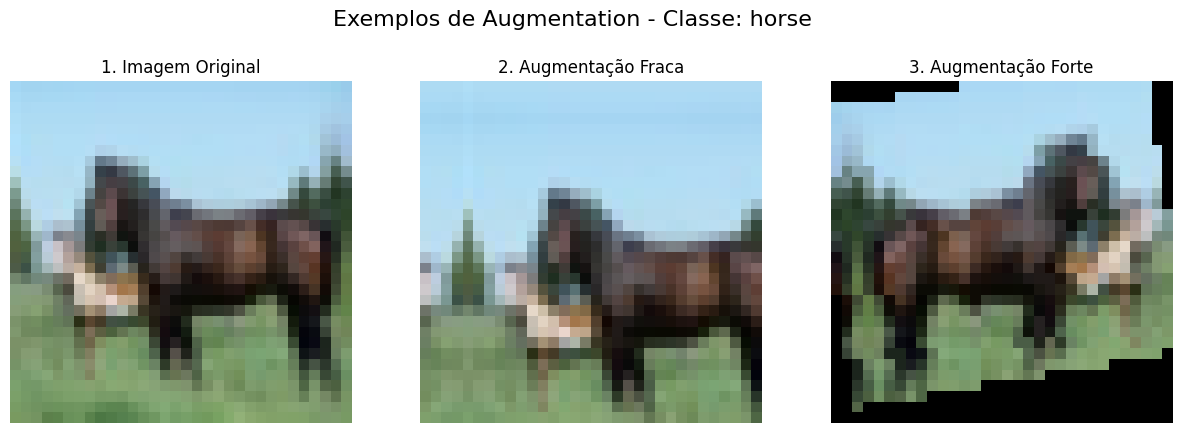

In [7]:
# Exemplo
index = 12
 # = np.random.randint(0, len(raw_train_dataset))

original_pil_img, label = raw_train_dataset[index]
img_tensor_weak = transform_weak(original_pil_img)
img_tensor_strong = transform_strong(original_pil_img)
img_plot_weak = denormalize(img_tensor_weak).permute(1, 2, 0)
img_plot_strong = denormalize(img_tensor_strong).permute(1, 2, 0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"Exemplos de Augmentation - Classe: {classes[label]}", fontsize=16)

# Imagem Original
ax1.imshow(original_pil_img)
ax1.set_title("1. Imagem Original")
ax1.axis('off')

ax2.imshow(img_plot_weak)
ax2.set_title("2. Augmentação Fraca")
ax2.axis('off')

ax3.imshow(img_plot_strong)
ax3.set_title("3. Augmentação Forte")
ax3.axis('off')

plt.show()

# Treino

In [ ]:
class FixMatchTrainer:
    def __init__(self, model_factory,batch_size=64, mu=7, lr=0.03, momentum=0.9, weight_decay=5e-4):
        """
        Inicializa o Trainer com os hiperparâmetros de treino
        """
        self.model_factory = model_factory
        self.model = None
        self.optimizer = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Hiperparâmetros
        self.batch_size = batch_size
        self.mu = mu
        self.unlabeled_batch_size = batch_size * mu
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay

        # Funções de Perda
        self.loss_s = nn.CrossEntropyLoss().to(self.device)
        self.loss_u = nn.CrossEntropyLoss(reduction='none').to(self.device)

        # Armazenamento de resultados (para comparação)
        self.results_history = {}
        print(f"Trainer inicializado. Rodando em: {self.device}")

    def _prepare_data(self, n_labels_per_class):
        """
        Encapsulando lógica de preparação de dados
        """

        # Carrega o Dataset
        raw_train_dataset = torchvision.datasets.CIFAR10(
            root='./data', train=True, download=False, transform=None)

        # Divide em parte com Rótulos e Parte sem
        labeled_indices, unlabeled_indices = get_split_indices(raw_train_dataset.targets, n_labels_per_class)
        labeled_subset_raw = Subset(raw_train_dataset, labeled_indices)
        unlabeled_subset_raw = Subset(raw_train_dataset, unlabeled_indices)

        # Prepara para Aplicar Data Augmentations
        labeled_dataset = LabeledDatasetWrapper(labeled_subset_raw, transform_weak)
        unlabeled_dataset = UnlabeledDatasetWrapper(unlabeled_subset_raw, transform_weak, transform_strong)

        # Cria Loaders de Treino
        labeled_loader = DataLoader(labeled_dataset, batch_size=self.batch_size,
                                    shuffle=True,num_workers=2, drop_last=False)

        unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=self.unlabeled_batch_size,
                                      shuffle=True,num_workers=2, drop_last=True)

        # Loader de Teste (Validação)
        test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

        test_loader = DataLoader(test_dataset, batch_size=self.batch_size * 2, shuffle=False, num_workers=2)

        return labeled_loader, unlabeled_loader, test_loader

    def _train_one_epoch(self, labeled_loader, unlabeled_loader):
        """
        Executa uma época de treino do FixMatch.
        """

        self.model.train()

        labeled_iter = iter(labeled_loader)
        unlabeled_iter = iter(unlabeled_loader)

        # Listas para guardar as perdas da época
        losses, losses_s, losses_u = [], [], []

        # A época é definida pelo loader não-rotulado (que é maior)
        pbar = tqdm(range(len(unlabeled_loader)), desc="Epoch Treino")

        for step in pbar:
            try:
                #  Pega batch rotulado
                l_inputs, l_targets = next(labeled_iter)
            except StopIteration:
                # Reinicia o iterador rotulado
                labeled_iter = iter(labeled_loader)
                l_inputs, l_targets = next(labeled_iter)

            # Pega batch não-rotulado
            (u_inputs_w, u_inputs_s) = next(unlabeled_iter)

            # Move tudo para a GPU
            l_inputs = l_inputs.to(self.device)
            l_targets = l_targets.to(self.device)
            u_inputs_w = u_inputs_w.to(self.device)
            u_inputs_s = u_inputs_s.to(self.device)

            # Concatena e faz uma passagem forward
            inputs = torch.cat((l_inputs, u_inputs_w, u_inputs_s))
            all_logits = self.model(inputs)

            # Separa os logits
            labeled_batch_size = l_inputs.shape[0]
            l_logits = all_logits[:labeled_batch_size]
            u_w_logits = all_logits[labeled_batch_size : labeled_batch_size + self.unlabeled_batch_size]
            u_s_logits = all_logits[labeled_batch_size + self.unlabeled_batch_size:]

            # --- Início da Lógica FixMatch ---

            # Calcula Loss Supervisionada (Ls)
            Ls = self.loss_s(l_logits, l_targets)

            # Calcula Pseudo-Rótulos (Professor)
            with torch.no_grad():
                probs = torch.softmax(u_w_logits, dim=1)
                max_probs, pseudo_labels = torch.max(probs, dim=1)
                mask = max_probs.ge(self.threshold).float() # TrashHold de Confiança

            # Calcula Loss Não-Supervisionada (Aluno)
            Lu_per_sample = self.loss_u(u_s_logits, pseudo_labels)
            Lu_masked = (Lu_per_sample * mask).mean()

            # Calcula a Loss Total
            loss = Ls + (self.lambda_u * Lu_masked)

            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Salva resultados
            losses.append(loss.item())
            losses_s.append(Ls.item())
            losses_u.append(Lu_masked.item())

            # Atualiza barra de progresso
            pbar.set_postfix(Loss=np.mean(losses), Ls=np.mean(losses_s), Lu=np.mean(losses_u))

        return np.mean(losses), np.mean(losses_s), np.mean(losses_u)

    def _validate(self, test_loader):
        """
        Valida o modelo no set de teste.
        """
        self.model.eval()
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                logits = self.model(inputs)
                _, predictions = torch.max(logits, dim=1)

                total_correct += (predictions == targets).sum().item()
                total_samples += targets.size(0)

        accuracy = 100 * total_correct / total_samples
        return accuracy

    def train(self, n_labels_per_class, num_epochs, run_name, lambda_u=1.0, threshold=0.95):
        """
        Método principal para iniciar um ciclo de treino.

        Args:
            n_labels_per_class (int): Qtde de rótulos por classe (ex: 40, 100, 400).
            num_epochs (int): Número de épocas para treinar.
            run_name (str): Nome para salvar os resultados (ex: "run_40_labels")
        """
        print(f"\n--- Iniciando Treino: {run_name} ---")
        print(f"  Labels por classe: {n_labels_per_class}")
        print(f"  Total de Épocas: {num_epochs}")

        self.lambda_u = lambda_u
        self.threshold = threshold

        # Reseta o modelo e o otimizador
        self.model = self.model_factory(num_classes=num_classes).to(self.device)
        self.optimizer = optim.SGD(
            self.model.parameters(), lr=self.lr,
            momentum=self.momentum, weight_decay=self.weight_decay, nesterov=True
        )

        # Prepara os dados para esta run
        labeled_loader, unlabeled_loader, test_loader = self._prepare_data(n_labels_per_class)

        print(f"  Total de imagens rotuladas: {len(labeled_loader.dataset)}")
        print(f"  Total de imagens não-rotuladas: {len(unlabeled_loader.dataset)}")
        print(f"  Batches rotulados/época: {len(labeled_loader)}")
        print(f"  Batches não-rotulados/época: {len(unlabeled_loader)} (define a época)")

        # Armazena histórico da run
        run_history = {
            "train_loss": [],
            "train_loss_s": [],
            "train_loss_u": [],
            "val_accuracy": []
        }

        best_val_acc = 0.0

        # Loop de Treino
        for epoch in range(num_epochs):
            print(f"\nÉpoca {epoch + 1}/{num_epochs}")

            # Treina
            loss, ls, lu = self._train_one_epoch(labeled_loader, unlabeled_loader)

            # Valida
            val_acc = self._validate(test_loader)

            print(f"Época {epoch + 1} - Val Acc: {val_acc:.2f}% | Loss Total: {loss:.4f} (Ls: {ls:.4f}, Lu: {lu:.4f})")

            # Salva histórico
            run_history["train_loss"].append(loss)
            run_history["train_loss_s"].append(ls)
            run_history["train_loss_u"].append(lu)
            run_history["val_accuracy"].append(val_acc)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                run_history["best_model_state"] = copy.deepcopy(self.model.state_dict())

        # Salva a run completa no histórico da classe
        self.results_history[run_name] = run_history
        print(f"--- Treino '{run_name}' Concluído ---")


def train_supervised_baseline(n_labels_per_class, num_epochs, run_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"  labels por classe: {n_labels_per_class}, épocas: {num_epochs}")

    raw_train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=False, transform=None)

    labeled_indices, _ = get_split_indices(raw_train_dataset.targets, n_labels_per_class)
    labeled_subset_raw = Subset(raw_train_dataset, labeled_indices)

    labeled_dataset = LabeledDatasetWrapper(labeled_subset_raw, transform_weak)

    labeled_loader = DataLoader(labeled_dataset, batch_size=64,
                                shuffle=True, num_workers=2)

    test_dataset_sl = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    test_loader_sl = DataLoader(test_dataset_sl, batch_size=128, shuffle=False, num_workers=2)

    print(f"  total de imagens rotuladas (baseline): {len(labeled_loader.dataset)}")

    model_sl = create_resnet18_cifar(num_classes=num_classes).to(device)
    optimizer_sl = optim.SGD(model_sl.parameters(), lr=0.03, momentum=0.9, weight_decay=5e-4, nesterov=True)
    loss_sl_fn = nn.CrossEntropyLoss().to(device)

    best_val_acc = 0.0
    history = {"val_accuracy": [], "train_loss": []}

    for epoch in range(num_epochs):
        model_sl.train()
        epoch_losses = []

        pbar = tqdm(labeled_loader, desc=f"época {epoch + 1}/{num_epochs} (sl)")

        for (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)

            logits = model_sl(inputs)
            loss = loss_sl_fn(logits, targets)

            optimizer_sl.zero_grad()
            loss.backward()
            optimizer_sl.step()

            epoch_losses.append(loss.item())
            pbar.set_postfix(loss=np.mean(epoch_losses))

        model_sl.eval()
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in test_loader_sl:
                inputs, targets = inputs.to(device), targets.to(device)
                logits = model_sl(inputs)
                _, predictions = torch.max(logits, dim=1)
                total_correct += (predictions == targets).sum().item()
                total_samples += targets.size(0)

        val_acc = 100 * total_correct / total_samples
        print(f"época {epoch + 1} - val acc (baseline): {val_acc:.2f}%")

        history["val_accuracy"].append(val_acc)
        history["train_loss"].append(np.mean(epoch_losses))

    print(f"--- treino baseline '{run_name}' concluído ---")

    trainer_comparison.results_history[run_name] = history

In [ ]:
# Cria o Trainer
trainer = FixMatchTrainer(
    model_factory=create_resnet18_cifar,
    batch_size=128,
    mu=7,
    lr=0.03
)

trainer.train(
    n_labels_per_class=1,
    num_epochs=30,
    run_name="Run_1_Labels_30_Epochs",
    threshold=0.95,
    lambda_u=1.0
)

trainer.train(
    n_labels_per_class=4,
    num_epochs=30,
    run_name="Run_4_Labels_30_Epochs",
    threshold=0.95,
    lambda_u=1.0
)

trainer.train(
    n_labels_per_class=25,
    num_epochs=30,
    run_name="Run_25_Labels_30_Epochs",
    threshold=0.95,
    lambda_u=1.0
)

trainer.train(
    n_labels_per_class=400,
    num_epochs=30,
    run_name="Run_400_Labels_30_Epochs",
    threshold=0.95,
    lambda_u=1.0
)

Trainer inicializado. Rodando em: cuda

--- Iniciando Treino: Run_1_Labels_30_Epochs ---
  Labels por classe: 1
  Total de Épocas: 30


KeyboardInterrupt: 

In [ ]:
runs_para_comparar = {
    "Run_1_Labels_30_Epochs": trainer.results_history["Run_1_Labels_30_Epochs"],
    "Run_4_Labels_30_Epochs": trainer.results_history["Run_4_Labels_30_Epochs"],
    "Run_25_Labels_30_Epochs": trainer.results_history["Run_25_Labels_30_Epochs"],
    "Run_400_Labels_30_Epochs": trainer.results_history["Run_400_Labels_30_Epochs"]
}

print("Mostrando comparação das runs:")
plot_histories(runs_para_comparar)

In [ ]:
print("Salvando os melhores pesos de todas as 'runs'...")

for run_name, history in trainer.results_history.items():

    best_weights = history.get("best_model_state")

    if best_weights:
        file_path = f"{run_name}_best_model.pth"

        try:
            # Salva os pesos no arquivo
            torch.save(best_weights, file_path)
            print(f"  -> Pesos de '{run_name}' salvos com sucesso em: {file_path}")
        except Exception as e:
            print(f"  -> FALHA ao salvar '{run_name}': {e}")
    else:
        print(f"  -> Pular '{run_name}': Nenhum peso (best_model_state) encontrado.")

print("Salvamento concluído.")

In [ ]:
run_name = "Run_1_Labels_30_Epochs"

print("\nMostrando visualização de pseudo-rótulos...")
show_pseudo_labels(trainer, num_images=5)

In [ ]:
run_name = "Run_4_Labels_30_Epochs"

print("\nMostrando visualização de pseudo-rótulos...")
show_pseudo_labels(trainer, num_images=5)

In [ ]:
run_name = "Run_25_Labels_30_Epochs"

print("\nMostrando visualização de pseudo-rótulos...")
show_pseudo_labels(trainer, num_images=5)

In [ ]:
run_name = "Run_400_Labels_30_Epochs"

print("\nMostrando visualização de pseudo-rótulos...")
show_pseudo_labels(trainer, num_images=5)

In [ ]:
# ==========================================
#         DEFINIÇÃO DO EXPERIMENTO
# ==========================================

# 1. O trainer que vai rodar e guardar todos os resultados
trainer_comparison = FixMatchTrainer(
    model_factory=create_resnet18_cifar,
    batch_size=128,
    mu=7,
    lr=0.03
)

# 2. Parâmetros do experimento
N_EPOCHS = 30
LABEL_COUNTS_PARA_TESTAR = [1, 4]
THRESHOLDS_PARA_TESTAR = [0.99, 0.95, 0.80]


Trainer inicializado. Rodando em: cuda


In [ ]:

# ==========================================
#         EXECUÇÃO DO EXPERIMENTO
# ==========================================

for n_labels in LABEL_COUNTS_PARA_TESTAR:

    print(f"\n===========================================================")
    print(f"   INICIANDO TESTES com {n_labels} RÓTULO(S) POR CLASSE   ")
    print(f"===========================================================\n")

    # Teste Baseline (supervisionado)
    baseline_run_name = f"baseline_{n_labels}_labels_sl"
    train_supervised_baseline(
        n_labels_per_class=n_labels,
        num_epochs=N_EPOCHS,
        run_name=baseline_run_name
    )

    # Testes FixMatch
    for thresh in THRESHOLDS_PARA_TESTAR:

        fixmatch_run_name = f"fixmatch_{n_labels}_labels_thresh_{thresh}"

        trainer_comparison.train(
            n_labels_per_class=n_labels,
            num_epochs=N_EPOCHS,
            run_name=fixmatch_run_name,
            threshold=thresh,
            lambda_u=1.0 
        )

print("\n=========================================")
print("   TODOS OS EXPERIMENTOS CONCLUÍDOS   ")
print("=========================================\n")

Trainer inicializado. Rodando em: cuda

   INICIANDO TESTES com 1 RÓTULO(S) POR CLASSE   


--- iniciando treino baseline: baseline_1_labels_sl ---
  labels por classe: 1, épocas: 30
  total de imagens rotuladas (baseline): 10


época 1/30 (sl): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it, loss=2.48]


época 1 - val acc (baseline): 10.00%


época 2/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s, loss=2.14]


época 2 - val acc (baseline): 10.00%


época 3/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 11.03it/s, loss=1.97]


época 3 - val acc (baseline): 10.00%


época 4/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 10.69it/s, loss=1.22]


época 4 - val acc (baseline): 10.00%


época 5/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 10.37it/s, loss=0.778]


época 5 - val acc (baseline): 10.00%


época 6/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 10.77it/s, loss=0.569]


época 6 - val acc (baseline): 10.01%


época 7/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  9.76it/s, loss=0.376]


época 7 - val acc (baseline): 9.99%


época 8/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  9.92it/s, loss=0.166]


época 8 - val acc (baseline): 10.01%


época 9/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 10.57it/s, loss=0.157]


época 9 - val acc (baseline): 9.99%


época 10/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 10.91it/s, loss=0.0681]


época 10 - val acc (baseline): 10.00%


época 11/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 11.49it/s, loss=0.0688]


época 11 - val acc (baseline): 10.01%


época 12/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 10.77it/s, loss=0.0808]


época 12 - val acc (baseline): 12.86%


época 13/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 11.17it/s, loss=0.0193]


época 13 - val acc (baseline): 9.95%


época 14/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 11.07it/s, loss=0.206]


época 14 - val acc (baseline): 10.00%


época 15/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 10.94it/s, loss=0.0323]


época 15 - val acc (baseline): 9.99%


época 16/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 10.31it/s, loss=0.0135]


época 16 - val acc (baseline): 10.00%


época 17/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 11.01it/s, loss=0.08]


época 17 - val acc (baseline): 10.01%


época 18/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 10.71it/s, loss=0.0856]


época 18 - val acc (baseline): 10.00%


época 19/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 11.13it/s, loss=0.0351]


época 19 - val acc (baseline): 10.05%


época 20/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 11.17it/s, loss=0.0979]


época 20 - val acc (baseline): 10.30%


época 21/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 10.98it/s, loss=0.0332]


época 21 - val acc (baseline): 10.33%


época 22/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 11.03it/s, loss=0.0643]


época 22 - val acc (baseline): 10.33%


época 23/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 10.51it/s, loss=0.0797]


época 23 - val acc (baseline): 10.48%


época 24/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 11.26it/s, loss=0.189]


época 24 - val acc (baseline): 10.60%


época 25/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 11.96it/s, loss=0.46]


época 25 - val acc (baseline): 10.33%


época 26/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 11.29it/s, loss=0.0582]


época 26 - val acc (baseline): 10.51%


época 27/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 10.44it/s, loss=0.00786]


época 27 - val acc (baseline): 10.56%


época 28/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 12.11it/s, loss=0.0258]


época 28 - val acc (baseline): 10.75%


época 29/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 10.97it/s, loss=0.0122]


época 29 - val acc (baseline): 10.76%


época 30/30 (sl): 100%|██████████| 1/1 [00:00<00:00, 11.20it/s, loss=0.0159]


época 30 - val acc (baseline): 10.75%
--- treino baseline 'baseline_1_labels_sl' concluído ---

--- Iniciando Treino: fixmatch_1_labels_thresh_0.99 ---
  Labels por classe: 1
  Total de Épocas: 30
  Total de imagens rotuladas: 10
  Total de imagens não-rotuladas: 49990
  Batches rotulados/época: 1
  Batches não-rotulados/época: 55 (define a época)

Época 1/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.539, Ls=0.364, Lu=0.175] 


Época 1 - Val Acc: 17.60% | Loss Total: 0.5386 (Ls: 0.3637, Lu: 0.1750)

Época 2/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.114, Ls=0.0101, Lu=0.104]  


Época 2 - Val Acc: 14.86% | Loss Total: 0.1142 (Ls: 0.0101, Lu: 0.1041)

Época 3/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.084, Ls=0.0072, Lu=0.0768]  


Época 3 - Val Acc: 15.82% | Loss Total: 0.0840 (Ls: 0.0072, Lu: 0.0768)

Época 4/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.0673, Ls=0.00218, Lu=0.0651]


Época 4 - Val Acc: 15.78% | Loss Total: 0.0673 (Ls: 0.0022, Lu: 0.0651)

Época 5/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.22it/s, Loss=0.0659, Ls=0.00198, Lu=0.0639]


Época 5 - Val Acc: 16.23% | Loss Total: 0.0659 (Ls: 0.0020, Lu: 0.0639)

Época 6/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.106, Ls=0.00373, Lu=0.102]  


Época 6 - Val Acc: 18.90% | Loss Total: 0.1060 (Ls: 0.0037, Lu: 0.1023)

Época 7/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.0839, Ls=0.00178, Lu=0.0821]


Época 7 - Val Acc: 17.29% | Loss Total: 0.0839 (Ls: 0.0018, Lu: 0.0821)

Época 8/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.0772, Ls=0.0014, Lu=0.0758] 


Época 8 - Val Acc: 17.97% | Loss Total: 0.0772 (Ls: 0.0014, Lu: 0.0758)

Época 9/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.0939, Ls=0.00217, Lu=0.0918]


Época 9 - Val Acc: 17.83% | Loss Total: 0.0939 (Ls: 0.0022, Lu: 0.0918)

Época 10/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.0883, Ls=0.000968, Lu=0.0873]


Época 10 - Val Acc: 18.27% | Loss Total: 0.0883 (Ls: 0.0010, Lu: 0.0873)

Época 11/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.0735, Ls=0.000913, Lu=0.0726]


Época 11 - Val Acc: 19.85% | Loss Total: 0.0735 (Ls: 0.0009, Lu: 0.0726)

Época 12/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.0585, Ls=0.000679, Lu=0.0579]


Época 12 - Val Acc: 17.35% | Loss Total: 0.0585 (Ls: 0.0007, Lu: 0.0579)

Época 13/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.0496, Ls=0.00068, Lu=0.0489] 


Época 13 - Val Acc: 17.65% | Loss Total: 0.0496 (Ls: 0.0007, Lu: 0.0489)

Época 14/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.0564, Ls=0.000641, Lu=0.0558]


Época 14 - Val Acc: 17.80% | Loss Total: 0.0564 (Ls: 0.0006, Lu: 0.0558)

Época 15/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.0597, Ls=0.000578, Lu=0.0591]


Época 15 - Val Acc: 18.35% | Loss Total: 0.0597 (Ls: 0.0006, Lu: 0.0591)

Época 16/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.0704, Ls=0.00189, Lu=0.0685] 


Época 16 - Val Acc: 14.94% | Loss Total: 0.0704 (Ls: 0.0019, Lu: 0.0685)

Época 17/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.0638, Ls=0.00152, Lu=0.0623]


Época 17 - Val Acc: 14.11% | Loss Total: 0.0638 (Ls: 0.0015, Lu: 0.0623)

Época 18/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.0671, Ls=0.000664, Lu=0.0665]


Época 18 - Val Acc: 16.73% | Loss Total: 0.0671 (Ls: 0.0007, Lu: 0.0665)

Época 19/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.25it/s, Loss=0.0761, Ls=0.003, Lu=0.0731]  


Época 19 - Val Acc: 16.86% | Loss Total: 0.0761 (Ls: 0.0030, Lu: 0.0731)

Época 20/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.0635, Ls=0.000459, Lu=0.0631]


Época 20 - Val Acc: 16.29% | Loss Total: 0.0635 (Ls: 0.0005, Lu: 0.0631)

Época 21/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.26it/s, Loss=0.0574, Ls=0.000498, Lu=0.0569]


Época 21 - Val Acc: 16.08% | Loss Total: 0.0574 (Ls: 0.0005, Lu: 0.0569)

Época 22/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.26it/s, Loss=0.0616, Ls=0.000715, Lu=0.0609]


Época 22 - Val Acc: 15.08% | Loss Total: 0.0616 (Ls: 0.0007, Lu: 0.0609)

Época 23/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.26it/s, Loss=0.0567, Ls=0.00038, Lu=0.0564] 


Época 23 - Val Acc: 13.51% | Loss Total: 0.0567 (Ls: 0.0004, Lu: 0.0564)

Época 24/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.25it/s, Loss=0.0486, Ls=0.000425, Lu=0.0482]


Época 24 - Val Acc: 16.59% | Loss Total: 0.0486 (Ls: 0.0004, Lu: 0.0482)

Época 25/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.0614, Ls=0.00026, Lu=0.0611] 


Época 25 - Val Acc: 15.23% | Loss Total: 0.0614 (Ls: 0.0003, Lu: 0.0611)

Época 26/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.26it/s, Loss=0.0626, Ls=0.00034, Lu=0.0623] 


Época 26 - Val Acc: 15.05% | Loss Total: 0.0626 (Ls: 0.0003, Lu: 0.0623)

Época 27/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.26it/s, Loss=0.0527, Ls=0.000242, Lu=0.0525]


Época 27 - Val Acc: 15.60% | Loss Total: 0.0527 (Ls: 0.0002, Lu: 0.0525)

Época 28/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.25it/s, Loss=0.0518, Ls=0.000317, Lu=0.0515]


Época 28 - Val Acc: 16.06% | Loss Total: 0.0518 (Ls: 0.0003, Lu: 0.0515)

Época 29/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.25it/s, Loss=0.0549, Ls=0.000823, Lu=0.0541]


Época 29 - Val Acc: 17.38% | Loss Total: 0.0549 (Ls: 0.0008, Lu: 0.0541)

Época 30/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.0614, Ls=0.000479, Lu=0.0609]


Época 30 - Val Acc: 14.29% | Loss Total: 0.0614 (Ls: 0.0005, Lu: 0.0609)
--- Treino 'fixmatch_1_labels_thresh_0.99' Concluído ---

--- Iniciando Treino: fixmatch_1_labels_thresh_0.95 ---
  Labels por classe: 1
  Total de Épocas: 30
  Total de imagens rotuladas: 10
  Total de imagens não-rotuladas: 49990
  Batches rotulados/época: 1
  Batches não-rotulados/época: 55 (define a época)

Época 1/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.658, Ls=0.366, Lu=0.292] 


Época 1 - Val Acc: 11.81% | Loss Total: 0.6576 (Ls: 0.3661, Lu: 0.2916)

Época 2/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.213, Ls=0.0175, Lu=0.195]


Época 2 - Val Acc: 18.84% | Loss Total: 0.2125 (Ls: 0.0175, Lu: 0.1950)

Época 3/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.222, Ls=0.0129, Lu=0.209] 


Época 3 - Val Acc: 16.75% | Loss Total: 0.2218 (Ls: 0.0129, Lu: 0.2088)

Época 4/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.165, Ls=0.00444, Lu=0.16] 


Época 4 - Val Acc: 16.76% | Loss Total: 0.1647 (Ls: 0.0044, Lu: 0.1603)

Época 5/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.26it/s, Loss=0.146, Ls=0.00349, Lu=0.142]


Época 5 - Val Acc: 18.40% | Loss Total: 0.1457 (Ls: 0.0035, Lu: 0.1423)

Época 6/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.26it/s, Loss=0.176, Ls=0.0104, Lu=0.166] 


Época 6 - Val Acc: 14.96% | Loss Total: 0.1764 (Ls: 0.0104, Lu: 0.1660)

Época 7/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.26it/s, Loss=0.205, Ls=0.0168, Lu=0.189]


Época 7 - Val Acc: 16.91% | Loss Total: 0.2055 (Ls: 0.0168, Lu: 0.1887)

Época 8/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.26it/s, Loss=0.136, Ls=0.00476, Lu=0.132]


Época 8 - Val Acc: 18.32% | Loss Total: 0.1364 (Ls: 0.0048, Lu: 0.1316)

Época 9/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.26it/s, Loss=0.124, Ls=0.00217, Lu=0.122]


Época 9 - Val Acc: 17.60% | Loss Total: 0.1242 (Ls: 0.0022, Lu: 0.1220)

Época 10/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.25it/s, Loss=0.12, Ls=0.00145, Lu=0.118] 


Época 10 - Val Acc: 18.14% | Loss Total: 0.1198 (Ls: 0.0015, Lu: 0.1184)

Época 11/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.26it/s, Loss=0.12, Ls=0.00153, Lu=0.119]  


Época 11 - Val Acc: 19.38% | Loss Total: 0.1204 (Ls: 0.0015, Lu: 0.1189)

Época 12/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.26it/s, Loss=0.119, Ls=0.0011, Lu=0.118] 


Época 12 - Val Acc: 18.79% | Loss Total: 0.1189 (Ls: 0.0011, Lu: 0.1178)

Época 13/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.26it/s, Loss=0.105, Ls=0.00105, Lu=0.104]


Época 13 - Val Acc: 19.62% | Loss Total: 0.1050 (Ls: 0.0010, Lu: 0.1040)

Época 14/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.25it/s, Loss=0.0941, Ls=0.000981, Lu=0.0931]


Época 14 - Val Acc: 18.21% | Loss Total: 0.0941 (Ls: 0.0010, Lu: 0.0931)

Época 15/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.26it/s, Loss=0.102, Ls=0.000612, Lu=0.102]  


Época 15 - Val Acc: 19.24% | Loss Total: 0.1022 (Ls: 0.0006, Lu: 0.1015)

Época 16/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.25it/s, Loss=0.0885, Ls=0.000704, Lu=0.0878]


Época 16 - Val Acc: 18.52% | Loss Total: 0.0885 (Ls: 0.0007, Lu: 0.0878)

Época 17/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.27it/s, Loss=0.103, Ls=0.00184, Lu=0.101]   


Época 17 - Val Acc: 19.90% | Loss Total: 0.1032 (Ls: 0.0018, Lu: 0.1014)

Época 18/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.101, Ls=0.000934, Lu=0.0997]


Época 18 - Val Acc: 18.09% | Loss Total: 0.1006 (Ls: 0.0009, Lu: 0.0997)

Época 19/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.0818, Ls=0.000706, Lu=0.081] 


Época 19 - Val Acc: 17.54% | Loss Total: 0.0818 (Ls: 0.0007, Lu: 0.0810)

Época 20/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.0873, Ls=0.000338, Lu=0.087] 


Época 20 - Val Acc: 17.92% | Loss Total: 0.0873 (Ls: 0.0003, Lu: 0.0870)

Época 21/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.0903, Ls=0.000384, Lu=0.0899]


Época 21 - Val Acc: 17.76% | Loss Total: 0.0903 (Ls: 0.0004, Lu: 0.0899)

Época 22/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.0822, Ls=0.000298, Lu=0.0819]


Época 22 - Val Acc: 16.97% | Loss Total: 0.0822 (Ls: 0.0003, Lu: 0.0819)

Época 23/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.089, Ls=0.000363, Lu=0.0887] 


Época 23 - Val Acc: 17.86% | Loss Total: 0.0890 (Ls: 0.0004, Lu: 0.0887)

Época 24/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.0899, Ls=0.000358, Lu=0.0895]


Época 24 - Val Acc: 18.38% | Loss Total: 0.0899 (Ls: 0.0004, Lu: 0.0895)

Época 25/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.097, Ls=0.000932, Lu=0.0961] 


Época 25 - Val Acc: 18.90% | Loss Total: 0.0970 (Ls: 0.0009, Lu: 0.0961)

Época 26/30


Epoch Treino: 100%|██████████| 55/55 [00:46<00:00,  1.19it/s, Loss=0.0813, Ls=0.00108, Lu=0.0802] 


Época 26 - Val Acc: 17.66% | Loss Total: 0.0813 (Ls: 0.0011, Lu: 0.0802)

Época 27/30


Epoch Treino: 100%|██████████| 55/55 [00:46<00:00,  1.19it/s, Loss=0.177, Ls=0.0166, Lu=0.161]    


Época 27 - Val Acc: 18.93% | Loss Total: 0.1773 (Ls: 0.0166, Lu: 0.1607)

Época 28/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.215, Ls=0.00821, Lu=0.207]


Época 28 - Val Acc: 20.32% | Loss Total: 0.2152 (Ls: 0.0082, Lu: 0.2070)

Época 29/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.20it/s, Loss=0.177, Ls=0.00321, Lu=0.174]


Época 29 - Val Acc: 19.58% | Loss Total: 0.1773 (Ls: 0.0032, Lu: 0.1741)

Época 30/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.166, Ls=0.00167, Lu=0.164] 


Época 30 - Val Acc: 19.85% | Loss Total: 0.1657 (Ls: 0.0017, Lu: 0.1640)
--- Treino 'fixmatch_1_labels_thresh_0.95' Concluído ---

--- Iniciando Treino: fixmatch_1_labels_thresh_0.8 ---
  Labels por classe: 1
  Total de Épocas: 30
  Total de imagens rotuladas: 10
  Total de imagens não-rotuladas: 49990
  Batches rotulados/época: 1
  Batches não-rotulados/época: 55 (define a época)

Época 1/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.20it/s, Loss=0.819, Ls=0.354, Lu=0.464]


Época 1 - Val Acc: 16.18% | Loss Total: 0.8190 (Ls: 0.3545, Lu: 0.4645)

Época 2/30


Epoch Treino: 100%|██████████| 55/55 [00:46<00:00,  1.19it/s, Loss=0.418, Ls=0.0441, Lu=0.374]


Época 2 - Val Acc: 16.79% | Loss Total: 0.4183 (Ls: 0.0441, Lu: 0.3741)

Época 3/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.20it/s, Loss=0.289, Ls=0.00673, Lu=0.283]


Época 3 - Val Acc: 13.55% | Loss Total: 0.2893 (Ls: 0.0067, Lu: 0.2826)

Época 4/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.232, Ls=0.00276, Lu=0.23] 


Época 4 - Val Acc: 12.62% | Loss Total: 0.2323 (Ls: 0.0028, Lu: 0.2296)

Época 5/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.214, Ls=0.00253, Lu=0.211]


Época 5 - Val Acc: 11.70% | Loss Total: 0.2137 (Ls: 0.0025, Lu: 0.2111)

Época 6/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.189, Ls=0.00204, Lu=0.187]


Época 6 - Val Acc: 11.31% | Loss Total: 0.1885 (Ls: 0.0020, Lu: 0.1865)

Época 7/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.154, Ls=0.00146, Lu=0.152]


Época 7 - Val Acc: 11.74% | Loss Total: 0.1538 (Ls: 0.0015, Lu: 0.1523)

Época 8/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.20it/s, Loss=0.173, Ls=0.00261, Lu=0.171] 


Época 8 - Val Acc: 11.36% | Loss Total: 0.1734 (Ls: 0.0026, Lu: 0.1708)

Época 9/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.20it/s, Loss=0.179, Ls=0.011, Lu=0.168]  


Época 9 - Val Acc: 10.11% | Loss Total: 0.1788 (Ls: 0.0110, Lu: 0.1678)

Época 10/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.306, Ls=0.0264, Lu=0.279]


Época 10 - Val Acc: 16.90% | Loss Total: 0.3057 (Ls: 0.0264, Lu: 0.2793)

Época 11/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.188, Ls=0.00232, Lu=0.186]


Época 11 - Val Acc: 16.40% | Loss Total: 0.1882 (Ls: 0.0023, Lu: 0.1859)

Época 12/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.17, Ls=0.00151, Lu=0.168] 


Época 12 - Val Acc: 16.88% | Loss Total: 0.1698 (Ls: 0.0015, Lu: 0.1683)

Época 13/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.156, Ls=0.00133, Lu=0.154]


Época 13 - Val Acc: 16.85% | Loss Total: 0.1558 (Ls: 0.0013, Lu: 0.1545)

Época 14/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.148, Ls=0.000848, Lu=0.148]


Época 14 - Val Acc: 15.63% | Loss Total: 0.1484 (Ls: 0.0008, Lu: 0.1475)

Época 15/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.143, Ls=0.000935, Lu=0.142]


Época 15 - Val Acc: 16.19% | Loss Total: 0.1426 (Ls: 0.0009, Lu: 0.1417)

Época 16/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.148, Ls=0.00061, Lu=0.147] 


Época 16 - Val Acc: 16.09% | Loss Total: 0.1480 (Ls: 0.0006, Lu: 0.1474)

Época 17/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.142, Ls=0.000564, Lu=0.142]


Época 17 - Val Acc: 16.41% | Loss Total: 0.1423 (Ls: 0.0006, Lu: 0.1418)

Época 18/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.138, Ls=0.000718, Lu=0.137]


Época 18 - Val Acc: 15.16% | Loss Total: 0.1379 (Ls: 0.0007, Lu: 0.1371)

Época 19/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.138, Ls=0.00058, Lu=0.137] 


Época 19 - Val Acc: 16.01% | Loss Total: 0.1377 (Ls: 0.0006, Lu: 0.1371)

Época 20/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.129, Ls=0.000574, Lu=0.128]


Época 20 - Val Acc: 15.97% | Loss Total: 0.1290 (Ls: 0.0006, Lu: 0.1284)

Época 21/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.123, Ls=0.000444, Lu=0.122]


Época 21 - Val Acc: 16.29% | Loss Total: 0.1226 (Ls: 0.0004, Lu: 0.1221)

Época 22/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.122, Ls=0.000611, Lu=0.121]


Época 22 - Val Acc: 16.55% | Loss Total: 0.1218 (Ls: 0.0006, Lu: 0.1211)

Época 23/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.20it/s, Loss=0.122, Ls=0.000339, Lu=0.121]


Época 23 - Val Acc: 16.14% | Loss Total: 0.1217 (Ls: 0.0003, Lu: 0.1213)

Época 24/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.133, Ls=0.000389, Lu=0.132]


Época 24 - Val Acc: 16.19% | Loss Total: 0.1327 (Ls: 0.0004, Lu: 0.1323)

Época 25/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.13, Ls=0.000426, Lu=0.129] 


Época 25 - Val Acc: 16.21% | Loss Total: 0.1297 (Ls: 0.0004, Lu: 0.1292)

Época 26/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.121, Ls=0.000643, Lu=0.12] 


Época 26 - Val Acc: 17.03% | Loss Total: 0.1210 (Ls: 0.0006, Lu: 0.1203)

Época 27/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.22it/s, Loss=0.124, Ls=0.000325, Lu=0.124]


Época 27 - Val Acc: 15.66% | Loss Total: 0.1240 (Ls: 0.0003, Lu: 0.1237)

Época 28/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.124, Ls=0.000476, Lu=0.124]


Época 28 - Val Acc: 15.87% | Loss Total: 0.1242 (Ls: 0.0005, Lu: 0.1237)

Época 29/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.125, Ls=0.000368, Lu=0.125]


Época 29 - Val Acc: 16.66% | Loss Total: 0.1250 (Ls: 0.0004, Lu: 0.1247)

Época 30/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.20it/s, Loss=0.116, Ls=0.000345, Lu=0.116]


Época 30 - Val Acc: 15.42% | Loss Total: 0.1165 (Ls: 0.0003, Lu: 0.1161)
--- Treino 'fixmatch_1_labels_thresh_0.8' Concluído ---

   INICIANDO TESTES com 4 RÓTULO(S) POR CLASSE   


--- iniciando treino baseline: baseline_4_labels_sl ---
  labels por classe: 4, épocas: 30
  total de imagens rotuladas (baseline): 40


época 1/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s, loss=2.46]


época 1 - val acc (baseline): 10.01%


época 2/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s, loss=2.29]


época 2 - val acc (baseline): 10.33%


época 3/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s, loss=2.08]


época 3 - val acc (baseline): 10.40%


época 4/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s, loss=1.94]


época 4 - val acc (baseline): 9.98%


época 5/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s, loss=1.65]


época 5 - val acc (baseline): 12.26%


época 6/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s, loss=1.4]


época 6 - val acc (baseline): 14.39%


época 7/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s, loss=1.43]


época 7 - val acc (baseline): 10.73%


época 8/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s, loss=1.14]


época 8 - val acc (baseline): 12.30%


época 9/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s, loss=0.905]


época 9 - val acc (baseline): 11.92%


época 10/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s, loss=0.746]


época 10 - val acc (baseline): 12.95%


época 11/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s, loss=0.601]


época 11 - val acc (baseline): 11.05%


época 12/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s, loss=0.526]


época 12 - val acc (baseline): 11.75%


época 13/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s, loss=0.45]


época 13 - val acc (baseline): 14.16%


época 14/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s, loss=0.3]


época 14 - val acc (baseline): 16.69%


época 15/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s, loss=0.175]


época 15 - val acc (baseline): 15.65%


época 16/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.05it/s, loss=0.195]


época 16 - val acc (baseline): 15.78%


época 17/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s, loss=0.178]


época 17 - val acc (baseline): 16.45%


época 18/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s, loss=0.196]


época 18 - val acc (baseline): 16.64%


época 19/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s, loss=0.2]


época 19 - val acc (baseline): 16.46%


época 20/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.05it/s, loss=0.176]


época 20 - val acc (baseline): 16.76%


época 21/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s, loss=0.092]


época 21 - val acc (baseline): 17.31%


época 22/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s, loss=0.0862]


época 22 - val acc (baseline): 17.62%


época 23/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s, loss=0.0173]


época 23 - val acc (baseline): 18.21%


época 24/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s, loss=0.146]


época 24 - val acc (baseline): 14.59%


época 25/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s, loss=0.0419]


época 25 - val acc (baseline): 14.99%


época 26/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s, loss=0.0239]


época 26 - val acc (baseline): 15.16%


época 27/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s, loss=0.0661]


época 27 - val acc (baseline): 14.80%


época 28/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s, loss=0.17]


época 28 - val acc (baseline): 16.38%


época 29/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s, loss=0.0256]


época 29 - val acc (baseline): 17.47%


época 30/30 (sl): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s, loss=0.0318]


época 30 - val acc (baseline): 18.63%
--- treino baseline 'baseline_4_labels_sl' concluído ---

--- Iniciando Treino: fixmatch_4_labels_thresh_0.99 ---
  Labels por classe: 4
  Total de Épocas: 30
  Total de imagens rotuladas: 40
  Total de imagens não-rotuladas: 49960
  Batches rotulados/época: 1
  Batches não-rotulados/época: 55 (define a época)

Época 1/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.46, Ls=0.343, Lu=0.117]  


Época 1 - Val Acc: 24.43% | Loss Total: 0.4603 (Ls: 0.3431, Lu: 0.1173)

Época 2/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.131, Ls=0.0122, Lu=0.119]


Época 2 - Val Acc: 26.07% | Loss Total: 0.1315 (Ls: 0.0122, Lu: 0.1193)

Época 3/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.25it/s, Loss=0.138, Ls=0.0164, Lu=0.121]


Época 3 - Val Acc: 28.55% | Loss Total: 0.1377 (Ls: 0.0164, Lu: 0.1212)

Época 4/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.106, Ls=0.00339, Lu=0.103]


Época 4 - Val Acc: 25.86% | Loss Total: 0.1059 (Ls: 0.0034, Lu: 0.1026)

Época 5/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.13, Ls=0.0161, Lu=0.114]   


Época 5 - Val Acc: 24.09% | Loss Total: 0.1300 (Ls: 0.0161, Lu: 0.1139)

Época 6/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.094, Ls=0.00346, Lu=0.0906] 


Época 6 - Val Acc: 22.44% | Loss Total: 0.0940 (Ls: 0.0035, Lu: 0.0906)

Época 7/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.0642, Ls=0.00268, Lu=0.0615]


Época 7 - Val Acc: 21.61% | Loss Total: 0.0642 (Ls: 0.0027, Lu: 0.0615)

Época 8/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.22it/s, Loss=0.0709, Ls=0.00121, Lu=0.0697]


Época 8 - Val Acc: 22.31% | Loss Total: 0.0709 (Ls: 0.0012, Lu: 0.0697)

Época 9/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.25it/s, Loss=0.0584, Ls=0.00157, Lu=0.0569]


Época 9 - Val Acc: 21.34% | Loss Total: 0.0584 (Ls: 0.0016, Lu: 0.0569)

Época 10/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.0633, Ls=0.000948, Lu=0.0624]


Época 10 - Val Acc: 20.98% | Loss Total: 0.0633 (Ls: 0.0009, Lu: 0.0624)

Época 11/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.064, Ls=0.00139, Lu=0.0626] 


Época 11 - Val Acc: 22.72% | Loss Total: 0.0640 (Ls: 0.0014, Lu: 0.0626)

Época 12/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.0713, Ls=0.00137, Lu=0.0699]


Época 12 - Val Acc: 23.01% | Loss Total: 0.0713 (Ls: 0.0014, Lu: 0.0699)

Época 13/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.0639, Ls=0.00108, Lu=0.0628] 


Época 13 - Val Acc: 23.74% | Loss Total: 0.0639 (Ls: 0.0011, Lu: 0.0628)

Época 14/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.0695, Ls=0.00206, Lu=0.0674]


Época 14 - Val Acc: 22.54% | Loss Total: 0.0695 (Ls: 0.0021, Lu: 0.0674)

Época 15/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.0707, Ls=0.00167, Lu=0.069] 


Época 15 - Val Acc: 22.86% | Loss Total: 0.0707 (Ls: 0.0017, Lu: 0.0690)

Época 16/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.0977, Ls=0.00225, Lu=0.0955] 


Época 16 - Val Acc: 25.52% | Loss Total: 0.0977 (Ls: 0.0022, Lu: 0.0955)

Época 17/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.108, Ls=0.00667, Lu=0.101] 


Época 17 - Val Acc: 26.21% | Loss Total: 0.1080 (Ls: 0.0067, Lu: 0.1013)

Época 18/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.0896, Ls=0.00383, Lu=0.0858]


Época 18 - Val Acc: 25.15% | Loss Total: 0.0896 (Ls: 0.0038, Lu: 0.0858)

Época 19/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.0779, Ls=0.00181, Lu=0.0761]


Época 19 - Val Acc: 26.11% | Loss Total: 0.0779 (Ls: 0.0018, Lu: 0.0761)

Época 20/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.0699, Ls=0.00129, Lu=0.0686] 


Época 20 - Val Acc: 24.61% | Loss Total: 0.0699 (Ls: 0.0013, Lu: 0.0686)

Época 21/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.0631, Ls=0.00108, Lu=0.062]  


Época 21 - Val Acc: 22.21% | Loss Total: 0.0631 (Ls: 0.0011, Lu: 0.0620)

Época 22/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.0635, Ls=0.000732, Lu=0.0627]


Época 22 - Val Acc: 23.86% | Loss Total: 0.0635 (Ls: 0.0007, Lu: 0.0627)

Época 23/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.22it/s, Loss=0.0562, Ls=0.000807, Lu=0.0554]


Época 23 - Val Acc: 24.72% | Loss Total: 0.0562 (Ls: 0.0008, Lu: 0.0554)

Época 24/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.0542, Ls=0.000607, Lu=0.0536]


Época 24 - Val Acc: 24.19% | Loss Total: 0.0542 (Ls: 0.0006, Lu: 0.0536)

Época 25/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.0527, Ls=0.000496, Lu=0.0522]


Época 25 - Val Acc: 24.14% | Loss Total: 0.0527 (Ls: 0.0005, Lu: 0.0522)

Época 26/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.0539, Ls=0.00076, Lu=0.0532] 


Época 26 - Val Acc: 23.62% | Loss Total: 0.0539 (Ls: 0.0008, Lu: 0.0532)

Época 27/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.0597, Ls=0.000771, Lu=0.059] 


Época 27 - Val Acc: 26.71% | Loss Total: 0.0597 (Ls: 0.0008, Lu: 0.0590)

Época 28/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.0839, Ls=0.00321, Lu=0.0807] 


Época 28 - Val Acc: 27.01% | Loss Total: 0.0839 (Ls: 0.0032, Lu: 0.0807)

Época 29/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.0707, Ls=0.0017, Lu=0.069]  


Época 29 - Val Acc: 23.98% | Loss Total: 0.0707 (Ls: 0.0017, Lu: 0.0690)

Época 30/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.0603, Ls=0.00056, Lu=0.0597] 


Época 30 - Val Acc: 22.52% | Loss Total: 0.0603 (Ls: 0.0006, Lu: 0.0597)
--- Treino 'fixmatch_4_labels_thresh_0.99' Concluído ---

--- Iniciando Treino: fixmatch_4_labels_thresh_0.95 ---
  Labels por classe: 4
  Total de Épocas: 30
  Total de imagens rotuladas: 40
  Total de imagens não-rotuladas: 49960
  Batches rotulados/época: 1
  Batches não-rotulados/época: 55 (define a época)

Época 1/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.592, Ls=0.397, Lu=0.194] 


Época 1 - Val Acc: 19.69% | Loss Total: 0.5916 (Ls: 0.3971, Lu: 0.1945)

Época 2/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.273, Ls=0.0255, Lu=0.247]


Época 2 - Val Acc: 23.13% | Loss Total: 0.2729 (Ls: 0.0255, Lu: 0.2474)

Época 3/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.198, Ls=0.0115, Lu=0.187]


Época 3 - Val Acc: 22.49% | Loss Total: 0.1980 (Ls: 0.0115, Lu: 0.1866)

Época 4/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.212, Ls=0.0121, Lu=0.2]   


Época 4 - Val Acc: 21.08% | Loss Total: 0.2116 (Ls: 0.0121, Lu: 0.1995)

Época 5/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.22it/s, Loss=0.206, Ls=0.0104, Lu=0.196] 


Época 5 - Val Acc: 22.26% | Loss Total: 0.2064 (Ls: 0.0104, Lu: 0.1961)

Época 6/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.207, Ls=0.0111, Lu=0.196] 


Época 6 - Val Acc: 24.41% | Loss Total: 0.2073 (Ls: 0.0111, Lu: 0.1962)

Época 7/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.26it/s, Loss=0.172, Ls=0.00489, Lu=0.167]


Época 7 - Val Acc: 19.93% | Loss Total: 0.1716 (Ls: 0.0049, Lu: 0.1667)

Época 8/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.15, Ls=0.00315, Lu=0.146] 


Época 8 - Val Acc: 21.07% | Loss Total: 0.1496 (Ls: 0.0031, Lu: 0.1464)

Época 9/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.22it/s, Loss=0.145, Ls=0.00269, Lu=0.142]


Época 9 - Val Acc: 22.15% | Loss Total: 0.1450 (Ls: 0.0027, Lu: 0.1423)

Época 10/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.146, Ls=0.00352, Lu=0.142]


Época 10 - Val Acc: 19.88% | Loss Total: 0.1457 (Ls: 0.0035, Lu: 0.1422)

Época 11/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.181, Ls=0.0182, Lu=0.163]


Época 11 - Val Acc: 20.11% | Loss Total: 0.1812 (Ls: 0.0182, Lu: 0.1631)

Época 12/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.22it/s, Loss=0.12, Ls=0.0081, Lu=0.112]  


Época 12 - Val Acc: 19.76% | Loss Total: 0.1200 (Ls: 0.0081, Lu: 0.1119)

Época 13/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.116, Ls=0.0021, Lu=0.114] 


Época 13 - Val Acc: 20.78% | Loss Total: 0.1162 (Ls: 0.0021, Lu: 0.1141)

Época 14/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.109, Ls=0.00226, Lu=0.107] 


Época 14 - Val Acc: 18.99% | Loss Total: 0.1091 (Ls: 0.0023, Lu: 0.1069)

Época 15/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.174, Ls=0.00713, Lu=0.167] 


Época 15 - Val Acc: 23.81% | Loss Total: 0.1743 (Ls: 0.0071, Lu: 0.1672)

Época 16/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.158, Ls=0.00549, Lu=0.153]


Época 16 - Val Acc: 20.63% | Loss Total: 0.1584 (Ls: 0.0055, Lu: 0.1529)

Época 17/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.141, Ls=0.00376, Lu=0.138] 


Época 17 - Val Acc: 19.52% | Loss Total: 0.1415 (Ls: 0.0038, Lu: 0.1377)

Época 18/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.142, Ls=0.00323, Lu=0.138]


Época 18 - Val Acc: 21.95% | Loss Total: 0.1416 (Ls: 0.0032, Lu: 0.1384)

Época 19/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.25it/s, Loss=0.121, Ls=0.00133, Lu=0.12] 


Época 19 - Val Acc: 20.64% | Loss Total: 0.1210 (Ls: 0.0013, Lu: 0.1197)

Época 20/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.108, Ls=0.0017, Lu=0.106]  


Época 20 - Val Acc: 20.25% | Loss Total: 0.1080 (Ls: 0.0017, Lu: 0.1063)

Época 21/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.12, Ls=0.00207, Lu=0.118] 


Época 21 - Val Acc: 21.43% | Loss Total: 0.1197 (Ls: 0.0021, Lu: 0.1176)

Época 22/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.153, Ls=0.00254, Lu=0.151]


Época 22 - Val Acc: 20.20% | Loss Total: 0.1532 (Ls: 0.0025, Lu: 0.1507)

Época 23/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.207, Ls=0.00702, Lu=0.2]  


Época 23 - Val Acc: 17.97% | Loss Total: 0.2066 (Ls: 0.0070, Lu: 0.1995)

Época 24/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.25it/s, Loss=0.181, Ls=0.00545, Lu=0.175]


Época 24 - Val Acc: 21.48% | Loss Total: 0.1806 (Ls: 0.0054, Lu: 0.1751)

Época 25/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.134, Ls=0.00247, Lu=0.132]


Época 25 - Val Acc: 18.66% | Loss Total: 0.1342 (Ls: 0.0025, Lu: 0.1317)

Época 26/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.128, Ls=0.00203, Lu=0.126]


Época 26 - Val Acc: 18.81% | Loss Total: 0.1277 (Ls: 0.0020, Lu: 0.1257)

Época 27/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.115, Ls=0.00195, Lu=0.113] 


Época 27 - Val Acc: 20.23% | Loss Total: 0.1154 (Ls: 0.0020, Lu: 0.1135)

Época 28/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.121, Ls=0.00158, Lu=0.119]


Época 28 - Val Acc: 18.45% | Loss Total: 0.1208 (Ls: 0.0016, Lu: 0.1192)

Época 29/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.22it/s, Loss=0.118, Ls=0.00191, Lu=0.116] 


Época 29 - Val Acc: 16.92% | Loss Total: 0.1176 (Ls: 0.0019, Lu: 0.1157)

Época 30/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.108, Ls=0.00167, Lu=0.107] 


Época 30 - Val Acc: 17.49% | Loss Total: 0.1083 (Ls: 0.0017, Lu: 0.1066)
--- Treino 'fixmatch_4_labels_thresh_0.95' Concluído ---

--- Iniciando Treino: fixmatch_4_labels_thresh_0.8 ---
  Labels por classe: 4
  Total de Épocas: 30
  Total de imagens rotuladas: 40
  Total de imagens não-rotuladas: 49960
  Batches rotulados/época: 1
  Batches não-rotulados/época: 55 (define a época)

Época 1/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.777, Ls=0.395, Lu=0.382]


Época 1 - Val Acc: 24.69% | Loss Total: 0.7774 (Ls: 0.3952, Lu: 0.3822)

Época 2/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.424, Ls=0.0182, Lu=0.406]


Época 2 - Val Acc: 24.07% | Loss Total: 0.4238 (Ls: 0.0182, Lu: 0.4056)

Época 3/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.22it/s, Loss=0.393, Ls=0.0192, Lu=0.374]


Época 3 - Val Acc: 24.45% | Loss Total: 0.3927 (Ls: 0.0192, Lu: 0.3736)

Época 4/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.326, Ls=0.00817, Lu=0.318]


Época 4 - Val Acc: 23.29% | Loss Total: 0.3263 (Ls: 0.0082, Lu: 0.3182)

Época 5/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.328, Ls=0.00877, Lu=0.319]


Época 5 - Val Acc: 23.78% | Loss Total: 0.3278 (Ls: 0.0088, Lu: 0.3190)

Época 6/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.293, Ls=0.00514, Lu=0.288]


Época 6 - Val Acc: 20.38% | Loss Total: 0.2934 (Ls: 0.0051, Lu: 0.2882)

Época 7/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.273, Ls=0.00416, Lu=0.268]


Época 7 - Val Acc: 24.26% | Loss Total: 0.2726 (Ls: 0.0042, Lu: 0.2684)

Época 8/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.283, Ls=0.00372, Lu=0.279]


Época 8 - Val Acc: 25.26% | Loss Total: 0.2830 (Ls: 0.0037, Lu: 0.2793)

Época 9/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.274, Ls=0.00335, Lu=0.271]


Época 9 - Val Acc: 24.78% | Loss Total: 0.2745 (Ls: 0.0033, Lu: 0.2711)

Época 10/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.271, Ls=0.00349, Lu=0.268]


Época 10 - Val Acc: 27.21% | Loss Total: 0.2711 (Ls: 0.0035, Lu: 0.2676)

Época 11/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.265, Ls=0.00324, Lu=0.262]


Época 11 - Val Acc: 23.62% | Loss Total: 0.2650 (Ls: 0.0032, Lu: 0.2617)

Época 12/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.292, Ls=0.00247, Lu=0.29] 


Época 12 - Val Acc: 28.33% | Loss Total: 0.2923 (Ls: 0.0025, Lu: 0.2898)

Época 13/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s, Loss=0.342, Ls=0.00901, Lu=0.333]


Época 13 - Val Acc: 27.15% | Loss Total: 0.3423 (Ls: 0.0090, Lu: 0.3333)

Época 14/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.27it/s, Loss=0.313, Ls=0.00476, Lu=0.308]


Época 14 - Val Acc: 23.52% | Loss Total: 0.3128 (Ls: 0.0048, Lu: 0.3081)

Época 15/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.27it/s, Loss=0.272, Ls=0.0024, Lu=0.27]  


Época 15 - Val Acc: 29.10% | Loss Total: 0.2721 (Ls: 0.0024, Lu: 0.2697)

Época 16/30


Epoch Treino: 100%|██████████| 55/55 [00:42<00:00,  1.28it/s, Loss=0.342, Ls=0.00838, Lu=0.334]


Época 16 - Val Acc: 27.91% | Loss Total: 0.3421 (Ls: 0.0084, Lu: 0.3338)

Época 17/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.345, Ls=0.00995, Lu=0.335]


Época 17 - Val Acc: 25.67% | Loss Total: 0.3448 (Ls: 0.0099, Lu: 0.3349)

Época 18/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.247, Ls=0.00277, Lu=0.244]


Época 18 - Val Acc: 26.42% | Loss Total: 0.2472 (Ls: 0.0028, Lu: 0.2444)

Época 19/30


Epoch Treino: 100%|██████████| 55/55 [00:42<00:00,  1.28it/s, Loss=0.255, Ls=0.00301, Lu=0.252]


Época 19 - Val Acc: 26.42% | Loss Total: 0.2550 (Ls: 0.0030, Lu: 0.2520)

Época 20/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.245, Ls=0.00213, Lu=0.243]


Época 20 - Val Acc: 27.44% | Loss Total: 0.2450 (Ls: 0.0021, Lu: 0.2429)

Época 21/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.28it/s, Loss=0.242, Ls=0.00346, Lu=0.239]


Época 21 - Val Acc: 26.19% | Loss Total: 0.2422 (Ls: 0.0035, Lu: 0.2387)

Época 22/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.27it/s, Loss=0.245, Ls=0.00194, Lu=0.243]


Época 22 - Val Acc: 28.47% | Loss Total: 0.2450 (Ls: 0.0019, Lu: 0.2430)

Época 23/30


Epoch Treino: 100%|██████████| 55/55 [00:42<00:00,  1.28it/s, Loss=0.226, Ls=0.00166, Lu=0.225] 


Época 23 - Val Acc: 24.05% | Loss Total: 0.2263 (Ls: 0.0017, Lu: 0.2246)

Época 24/30


Epoch Treino: 100%|██████████| 55/55 [00:42<00:00,  1.28it/s, Loss=0.244, Ls=0.00185, Lu=0.243]


Época 24 - Val Acc: 29.11% | Loss Total: 0.2444 (Ls: 0.0019, Lu: 0.2425)

Época 25/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.25it/s, Loss=0.251, Ls=0.00342, Lu=0.247]


Época 25 - Val Acc: 26.67% | Loss Total: 0.2509 (Ls: 0.0034, Lu: 0.2475)

Época 26/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, Loss=0.241, Ls=0.00237, Lu=0.239]


Época 26 - Val Acc: 27.99% | Loss Total: 0.2412 (Ls: 0.0024, Lu: 0.2389)

Época 27/30


Epoch Treino: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s, Loss=0.277, Ls=0.00197, Lu=0.275]


Época 27 - Val Acc: 28.46% | Loss Total: 0.2771 (Ls: 0.0020, Lu: 0.2752)

Época 28/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.236, Ls=0.00218, Lu=0.234]


Época 28 - Val Acc: 29.28% | Loss Total: 0.2359 (Ls: 0.0022, Lu: 0.2337)

Época 29/30


Epoch Treino: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, Loss=0.238, Ls=0.00205, Lu=0.236]


Época 29 - Val Acc: 27.64% | Loss Total: 0.2377 (Ls: 0.0021, Lu: 0.2357)

Época 30/30


Epoch Treino: 100%|██████████| 55/55 [00:43<00:00,  1.27it/s, Loss=0.242, Ls=0.00246, Lu=0.24]  


Época 30 - Val Acc: 27.76% | Loss Total: 0.2425 (Ls: 0.0025, Lu: 0.2400)
--- Treino 'fixmatch_4_labels_thresh_0.8' Concluído ---

   TODOS OS EXPERIMENTOS CONCLUÍDOS   

Plotando comparação para 4 RÓTULOS:


KeyError: 'fixmatch_4_labels_thresh_0.80'

Plotando comparação para 4 RÓTULOS:


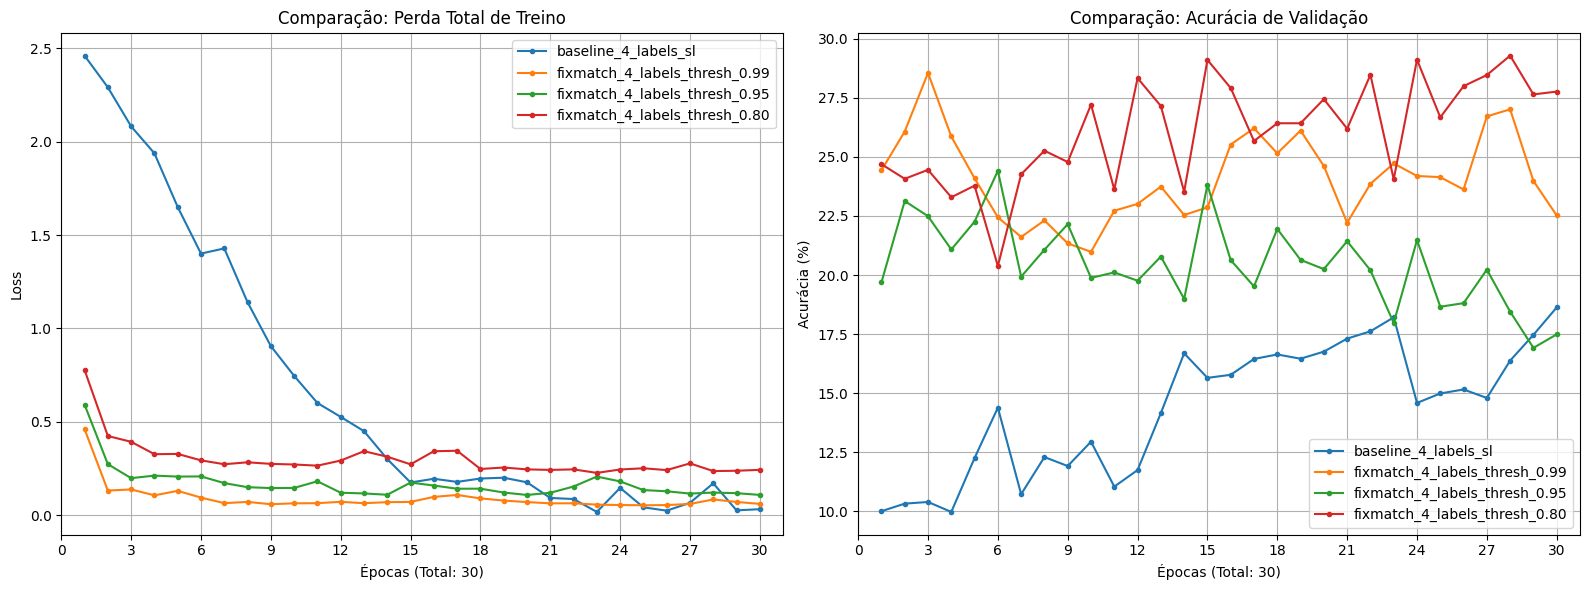

Plotando comparação para 1 RÓTULO:


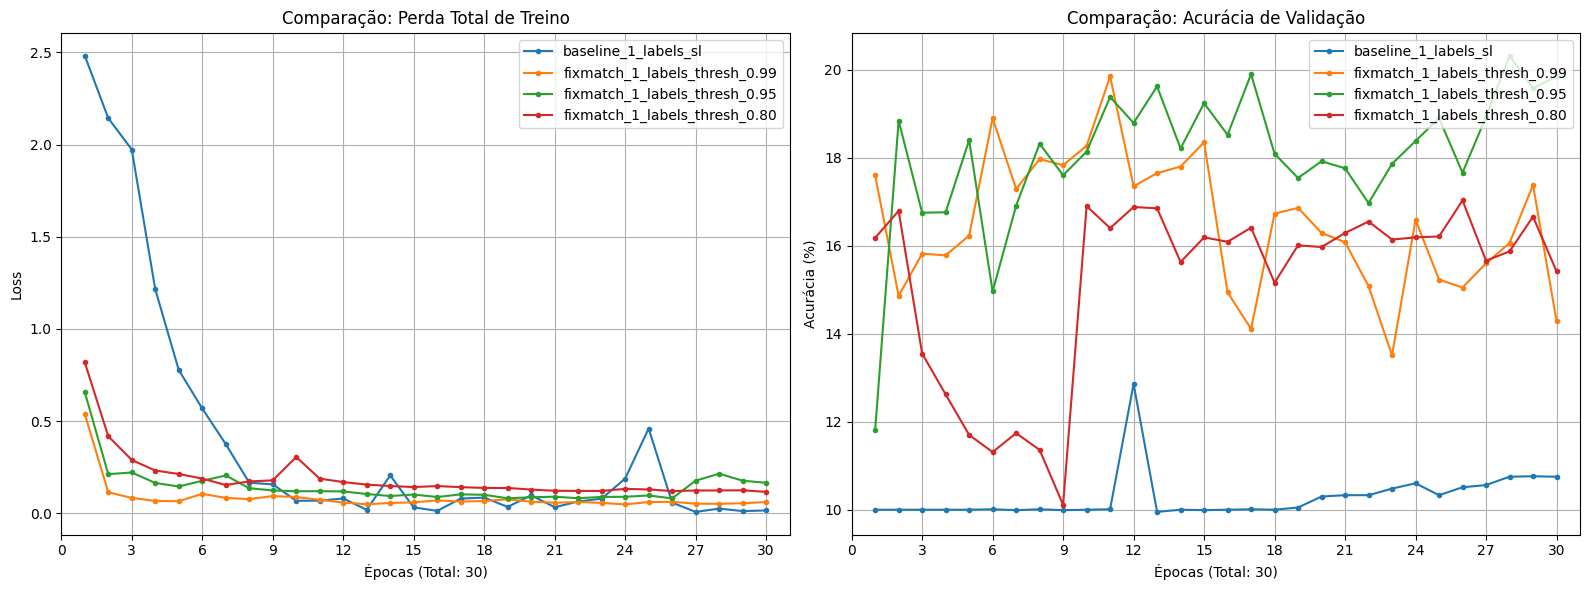

In [ ]:
print("Plotando comparação para 4 RÓTULOS:")

runs_para_comparar_4 = {
    "baseline_4_labels_sl": trainer_comparison.results_history["baseline_4_labels_sl"],
    "fixmatch_4_labels_thresh_0.99": trainer_comparison.results_history["fixmatch_4_labels_thresh_0.99"],
    "fixmatch_4_labels_thresh_0.95": trainer_comparison.results_history["fixmatch_4_labels_thresh_0.95"],
    "fixmatch_4_labels_thresh_0.80": trainer_comparison.results_history["fixmatch_4_labels_thresh_0.8"]
}
plot_histories(runs_para_comparar_4)


print("Plotando comparação para 1 RÓTULO:")

runs_para_comparar_1 = {
    "baseline_1_labels_sl": trainer_comparison.results_history["baseline_1_labels_sl"],
    "fixmatch_1_labels_thresh_0.99": trainer_comparison.results_history["fixmatch_1_labels_thresh_0.99"],
    "fixmatch_1_labels_thresh_0.95": trainer_comparison.results_history["fixmatch_1_labels_thresh_0.95"],
    "fixmatch_1_labels_thresh_0.80": trainer_comparison.results_history["fixmatch_1_labels_thresh_0.8"]
}
plot_histories(runs_para_comparar_1)

In [ ]:
# ==========================================
#              EXPERIMENTOS
# ==========================================

trainer.train(
    n_labels_per_class=25,
    num_epochs=30,
    run_name="Run_25_Labels_30_Epochs",
    threshold=0.95,
    lambda_u=1.0
)

trainer_comparison = FixMatchTrainer(
    model_factory=create_resnet18_cifar,
    batch_size=128,
    mu=7,
    lr=0.03
)

n_labels = 25
n_epochs = 30

# Teste supervisionado
train_supervised_baseline(
    n_labels_per_class=n_labels,
    num_epochs=n_epochs,
    run_name=f"baseline_{n_labels}_labels_sl"
)

# Teste FixMatch
trainer_comparison.train(
    n_labels_per_class=n_labels,
    num_epochs=n_epochs,
    run_name=f"run_{n_labels}_labels_thresh_0.85",
    threshold=0.85
)

trainer_comparison.train(
    n_labels_per_class=n_labels,
    num_epochs=n_epochs,
    run_name=f"run_{n_labels}_labels_thresh_0.75",
    threshold=0.75
)


--- Iniciando Treino: Run_25_Labels_30_Epochs ---
  Labels por classe: 25
  Total de Épocas: 30
  Total de imagens rotuladas: 250
  Total de imagens não-rotuladas: 49750
  Batches rotulados/época: 2
  Batches não-rotulados/época: 55 (define a época)

Época 1/30


Epoch Treino: 100%|██████████| 55/55 [01:20<00:00,  1.46s/it, Loss=1.07, Ls=0.959, Lu=0.111]


Época 1 - Val Acc: 31.53% | Loss Total: 1.0701 (Ls: 0.9590, Lu: 0.1111)

Época 2/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it, Loss=0.366, Ls=0.0874, Lu=0.279]


Época 2 - Val Acc: 38.97% | Loss Total: 0.3660 (Ls: 0.0874, Lu: 0.2786)

Época 3/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.38s/it, Loss=0.309, Ls=0.039, Lu=0.27]


Época 3 - Val Acc: 38.93% | Loss Total: 0.3095 (Ls: 0.0390, Lu: 0.2705)

Época 4/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it, Loss=0.307, Ls=0.033, Lu=0.274]


Época 4 - Val Acc: 39.91% | Loss Total: 0.3073 (Ls: 0.0330, Lu: 0.2743)

Época 5/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it, Loss=0.286, Ls=0.0216, Lu=0.265]


Época 5 - Val Acc: 40.76% | Loss Total: 0.2864 (Ls: 0.0216, Lu: 0.2648)

Época 6/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.287, Ls=0.0195, Lu=0.267]


Época 6 - Val Acc: 41.98% | Loss Total: 0.2870 (Ls: 0.0195, Lu: 0.2675)

Época 7/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.38s/it, Loss=0.274, Ls=0.0135, Lu=0.261]


Época 7 - Val Acc: 43.03% | Loss Total: 0.2745 (Ls: 0.0135, Lu: 0.2609)

Época 8/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.39s/it, Loss=0.273, Ls=0.0153, Lu=0.258]


Época 8 - Val Acc: 42.90% | Loss Total: 0.2733 (Ls: 0.0153, Lu: 0.2580)

Época 9/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.38s/it, Loss=0.268, Ls=0.0142, Lu=0.253]


Época 9 - Val Acc: 43.22% | Loss Total: 0.2676 (Ls: 0.0142, Lu: 0.2534)

Época 10/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it, Loss=0.261, Ls=0.0125, Lu=0.248]


Época 10 - Val Acc: 45.49% | Loss Total: 0.2610 (Ls: 0.0125, Lu: 0.2485)

Época 11/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it, Loss=0.267, Ls=0.0133, Lu=0.254]


Época 11 - Val Acc: 46.20% | Loss Total: 0.2669 (Ls: 0.0133, Lu: 0.2536)

Época 12/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.38s/it, Loss=0.259, Ls=0.0116, Lu=0.247]


Época 12 - Val Acc: 46.16% | Loss Total: 0.2587 (Ls: 0.0116, Lu: 0.2471)

Época 13/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it, Loss=0.252, Ls=0.0112, Lu=0.241]


Época 13 - Val Acc: 46.13% | Loss Total: 0.2520 (Ls: 0.0112, Lu: 0.2408)

Época 14/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it, Loss=0.24, Ls=0.00867, Lu=0.231]


Época 14 - Val Acc: 44.54% | Loss Total: 0.2396 (Ls: 0.0087, Lu: 0.2310)

Época 15/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.38s/it, Loss=0.246, Ls=0.00899, Lu=0.237]


Época 15 - Val Acc: 46.78% | Loss Total: 0.2460 (Ls: 0.0090, Lu: 0.2370)

Época 16/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.38s/it, Loss=0.257, Ls=0.00982, Lu=0.247]


Época 16 - Val Acc: 47.56% | Loss Total: 0.2567 (Ls: 0.0098, Lu: 0.2469)

Época 17/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.38s/it, Loss=0.247, Ls=0.0094, Lu=0.237]


Época 17 - Val Acc: 48.21% | Loss Total: 0.2469 (Ls: 0.0094, Lu: 0.2375)

Época 18/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.39s/it, Loss=0.238, Ls=0.00778, Lu=0.231]


Época 18 - Val Acc: 47.57% | Loss Total: 0.2383 (Ls: 0.0078, Lu: 0.2305)

Época 19/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.39s/it, Loss=0.239, Ls=0.00909, Lu=0.23]


Época 19 - Val Acc: 47.81% | Loss Total: 0.2387 (Ls: 0.0091, Lu: 0.2296)

Época 20/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.38s/it, Loss=0.24, Ls=0.00695, Lu=0.233]


Época 20 - Val Acc: 49.38% | Loss Total: 0.2403 (Ls: 0.0069, Lu: 0.2333)

Época 21/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.38s/it, Loss=0.245, Ls=0.00767, Lu=0.238]


Época 21 - Val Acc: 47.78% | Loss Total: 0.2454 (Ls: 0.0077, Lu: 0.2378)

Época 22/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.39s/it, Loss=0.226, Ls=0.00683, Lu=0.219]


Época 22 - Val Acc: 49.08% | Loss Total: 0.2262 (Ls: 0.0068, Lu: 0.2194)

Época 23/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.40s/it, Loss=0.22, Ls=0.00507, Lu=0.215]


Época 23 - Val Acc: 49.33% | Loss Total: 0.2200 (Ls: 0.0051, Lu: 0.2150)

Época 24/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.40s/it, Loss=0.238, Ls=0.00614, Lu=0.232]


Época 24 - Val Acc: 49.27% | Loss Total: 0.2381 (Ls: 0.0061, Lu: 0.2320)

Época 25/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.38s/it, Loss=0.235, Ls=0.00577, Lu=0.229]


Época 25 - Val Acc: 47.77% | Loss Total: 0.2350 (Ls: 0.0058, Lu: 0.2292)

Época 26/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.38s/it, Loss=0.237, Ls=0.00866, Lu=0.228]


Época 26 - Val Acc: 48.64% | Loss Total: 0.2369 (Ls: 0.0087, Lu: 0.2283)

Época 27/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.38s/it, Loss=0.233, Ls=0.00684, Lu=0.226]


Época 27 - Val Acc: 49.53% | Loss Total: 0.2328 (Ls: 0.0068, Lu: 0.2259)

Época 28/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.38s/it, Loss=0.235, Ls=0.00744, Lu=0.228]


Época 28 - Val Acc: 49.96% | Loss Total: 0.2354 (Ls: 0.0074, Lu: 0.2279)

Época 29/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.39s/it, Loss=0.222, Ls=0.0039, Lu=0.218]


Época 29 - Val Acc: 49.78% | Loss Total: 0.2220 (Ls: 0.0039, Lu: 0.2181)

Época 30/30


Epoch Treino: 100%|██████████| 55/55 [01:17<00:00,  1.40s/it, Loss=0.211, Ls=0.00419, Lu=0.207]


Época 30 - Val Acc: 50.71% | Loss Total: 0.2115 (Ls: 0.0042, Lu: 0.2073)
--- Treino 'Run_25_Labels_30_Epochs' Concluído ---
Trainer inicializado. Rodando em: cuda

--- iniciando treino baseline: baseline_25_labels_sl ---
  labels por classe: 25, épocas: 30
  total de imagens rotuladas (baseline): 250


época 1/30 (sl): 100%|██████████| 4/4 [00:00<00:00,  8.76it/s, loss=2.97]


época 1 - val acc (baseline): 10.16%


época 2/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.84it/s, loss=3.48]


época 2 - val acc (baseline): 12.26%


época 3/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 14.38it/s, loss=2.88]


época 3 - val acc (baseline): 16.96%


época 4/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.33it/s, loss=1.94]


época 4 - val acc (baseline): 22.85%


época 5/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 12.37it/s, loss=1.77]


época 5 - val acc (baseline): 20.74%


época 6/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.57it/s, loss=1.56]


época 6 - val acc (baseline): 22.73%


época 7/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.19it/s, loss=1.2]


época 7 - val acc (baseline): 26.65%


época 8/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.45it/s, loss=1.11]


época 8 - val acc (baseline): 31.58%


época 9/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.20it/s, loss=1.12]


época 9 - val acc (baseline): 29.07%


época 10/30 (sl): 100%|██████████| 4/4 [00:00<00:00,  9.58it/s, loss=1.1]


época 10 - val acc (baseline): 31.72%


época 11/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.78it/s, loss=0.916]


época 11 - val acc (baseline): 28.56%


época 12/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.76it/s, loss=0.984]


época 12 - val acc (baseline): 33.91%


época 13/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 14.13it/s, loss=0.875]


época 13 - val acc (baseline): 32.84%


época 14/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.95it/s, loss=0.764]


época 14 - val acc (baseline): 36.21%


época 15/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.58it/s, loss=0.602]


época 15 - val acc (baseline): 33.47%


época 16/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.38it/s, loss=0.711]


época 16 - val acc (baseline): 32.76%


época 17/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.58it/s, loss=0.45]


época 17 - val acc (baseline): 34.71%


época 18/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.34it/s, loss=0.409]


época 18 - val acc (baseline): 32.17%


época 19/30 (sl): 100%|██████████| 4/4 [00:00<00:00,  9.33it/s, loss=0.353]


época 19 - val acc (baseline): 34.41%


época 20/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.87it/s, loss=0.346]


época 20 - val acc (baseline): 35.99%


época 21/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.78it/s, loss=0.326]


época 21 - val acc (baseline): 35.78%


época 22/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 14.19it/s, loss=0.405]


época 22 - val acc (baseline): 32.32%


época 23/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 10.09it/s, loss=0.563]


época 23 - val acc (baseline): 30.85%


época 24/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.74it/s, loss=0.429]


época 24 - val acc (baseline): 33.04%


época 25/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.66it/s, loss=0.539]


época 25 - val acc (baseline): 31.91%


época 26/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.65it/s, loss=0.395]


época 26 - val acc (baseline): 33.82%


época 27/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.23it/s, loss=0.405]


época 27 - val acc (baseline): 33.22%


época 28/30 (sl): 100%|██████████| 4/4 [00:00<00:00,  9.93it/s, loss=0.292]


época 28 - val acc (baseline): 35.58%


época 29/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.94it/s, loss=0.264]


época 29 - val acc (baseline): 36.43%


época 30/30 (sl): 100%|██████████| 4/4 [00:00<00:00, 13.53it/s, loss=0.28]


época 30 - val acc (baseline): 34.46%
--- treino baseline 'baseline_25_labels_sl' concluído ---

--- Iniciando Treino: run_25_labels_thresh_0.85 ---
  Labels por classe: 25
  Total de Épocas: 30
  Total de imagens rotuladas: 250
  Total de imagens não-rotuladas: 49750
  Batches rotulados/época: 2
  Batches não-rotulados/época: 55 (define a época)

Época 1/30


Epoch Treino: 100%|██████████| 55/55 [01:17<00:00,  1.40s/it, Loss=1.21, Ls=0.984, Lu=0.225]


Época 1 - Val Acc: 34.09% | Loss Total: 1.2095 (Ls: 0.9840, Lu: 0.2255)

Época 2/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.40s/it, Loss=0.544, Ls=0.0886, Lu=0.455]


Época 2 - Val Acc: 39.93% | Loss Total: 0.5437 (Ls: 0.0886, Lu: 0.4551)

Época 3/30


Epoch Treino: 100%|██████████| 55/55 [01:17<00:00,  1.40s/it, Loss=0.496, Ls=0.0497, Lu=0.447]


Época 3 - Val Acc: 41.07% | Loss Total: 0.4964 (Ls: 0.0497, Lu: 0.4467)

Época 4/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.39s/it, Loss=0.449, Ls=0.0318, Lu=0.417]


Época 4 - Val Acc: 41.89% | Loss Total: 0.4490 (Ls: 0.0318, Lu: 0.4172)

Época 5/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.39s/it, Loss=0.449, Ls=0.0292, Lu=0.42]


Época 5 - Val Acc: 40.01% | Loss Total: 0.4495 (Ls: 0.0292, Lu: 0.4202)

Época 6/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.39s/it, Loss=0.427, Ls=0.0219, Lu=0.405]


Época 6 - Val Acc: 40.30% | Loss Total: 0.4271 (Ls: 0.0219, Lu: 0.4052)

Época 7/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.38s/it, Loss=0.424, Ls=0.0234, Lu=0.401]


Época 7 - Val Acc: 40.87% | Loss Total: 0.4240 (Ls: 0.0234, Lu: 0.4006)

Época 8/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.39s/it, Loss=0.402, Ls=0.0152, Lu=0.387]


Época 8 - Val Acc: 41.22% | Loss Total: 0.4022 (Ls: 0.0152, Lu: 0.3869)

Época 9/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.40s/it, Loss=0.404, Ls=0.0183, Lu=0.386]


Época 9 - Val Acc: 42.38% | Loss Total: 0.4044 (Ls: 0.0183, Lu: 0.3861)

Época 10/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.39s/it, Loss=0.374, Ls=0.0139, Lu=0.36]


Época 10 - Val Acc: 42.78% | Loss Total: 0.3743 (Ls: 0.0139, Lu: 0.3604)

Época 11/30


Epoch Treino: 100%|██████████| 55/55 [01:17<00:00,  1.41s/it, Loss=0.382, Ls=0.0152, Lu=0.367]


Época 11 - Val Acc: 44.62% | Loss Total: 0.3817 (Ls: 0.0152, Lu: 0.3665)

Época 12/30


Epoch Treino: 100%|██████████| 55/55 [01:17<00:00,  1.40s/it, Loss=0.383, Ls=0.0132, Lu=0.37]


Época 12 - Val Acc: 44.05% | Loss Total: 0.3830 (Ls: 0.0132, Lu: 0.3698)

Época 13/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.38s/it, Loss=0.354, Ls=0.00862, Lu=0.345]


Época 13 - Val Acc: 45.22% | Loss Total: 0.3536 (Ls: 0.0086, Lu: 0.3450)

Época 14/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.39s/it, Loss=0.343, Ls=0.00806, Lu=0.335]


Época 14 - Val Acc: 43.00% | Loss Total: 0.3427 (Ls: 0.0081, Lu: 0.3346)

Época 15/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.349, Ls=0.0101, Lu=0.338]


Época 15 - Val Acc: 42.29% | Loss Total: 0.3486 (Ls: 0.0101, Lu: 0.3385)

Época 16/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.362, Ls=0.0147, Lu=0.347]


Época 16 - Val Acc: 44.06% | Loss Total: 0.3621 (Ls: 0.0147, Lu: 0.3475)

Época 17/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it, Loss=0.342, Ls=0.0107, Lu=0.331]


Época 17 - Val Acc: 45.25% | Loss Total: 0.3420 (Ls: 0.0107, Lu: 0.3313)

Época 18/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.39s/it, Loss=0.338, Ls=0.0081, Lu=0.329]


Época 18 - Val Acc: 45.13% | Loss Total: 0.3375 (Ls: 0.0081, Lu: 0.3294)

Época 19/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it, Loss=0.341, Ls=0.00856, Lu=0.332]


Época 19 - Val Acc: 45.62% | Loss Total: 0.3408 (Ls: 0.0086, Lu: 0.3322)

Época 20/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it, Loss=0.344, Ls=0.00979, Lu=0.334]


Época 20 - Val Acc: 45.46% | Loss Total: 0.3443 (Ls: 0.0098, Lu: 0.3345)

Época 21/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.33, Ls=0.00574, Lu=0.324]


Época 21 - Val Acc: 45.47% | Loss Total: 0.3297 (Ls: 0.0057, Lu: 0.3239)

Época 22/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.33, Ls=0.00729, Lu=0.323]


Época 22 - Val Acc: 46.97% | Loss Total: 0.3305 (Ls: 0.0073, Lu: 0.3232)

Época 23/30


Epoch Treino: 100%|██████████| 55/55 [01:13<00:00,  1.35s/it, Loss=0.332, Ls=0.00683, Lu=0.325]


Época 23 - Val Acc: 45.35% | Loss Total: 0.3317 (Ls: 0.0068, Lu: 0.3249)

Época 24/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.36s/it, Loss=0.32, Ls=0.00657, Lu=0.313]


Época 24 - Val Acc: 47.46% | Loss Total: 0.3199 (Ls: 0.0066, Lu: 0.3134)

Época 25/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it, Loss=0.317, Ls=0.00677, Lu=0.311]


Época 25 - Val Acc: 47.25% | Loss Total: 0.3175 (Ls: 0.0068, Lu: 0.3107)

Época 26/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.33, Ls=0.00788, Lu=0.322]


Época 26 - Val Acc: 45.61% | Loss Total: 0.3303 (Ls: 0.0079, Lu: 0.3224)

Época 27/30


Epoch Treino: 100%|██████████| 55/55 [01:16<00:00,  1.40s/it, Loss=0.318, Ls=0.00622, Lu=0.312]


Época 27 - Val Acc: 47.78% | Loss Total: 0.3183 (Ls: 0.0062, Lu: 0.3121)

Época 28/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it, Loss=0.324, Ls=0.00567, Lu=0.318]


Época 28 - Val Acc: 47.77% | Loss Total: 0.3236 (Ls: 0.0057, Lu: 0.3180)

Época 29/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it, Loss=0.322, Ls=0.00591, Lu=0.316]


Época 29 - Val Acc: 47.24% | Loss Total: 0.3221 (Ls: 0.0059, Lu: 0.3162)

Época 30/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it, Loss=0.325, Ls=0.00842, Lu=0.317]


Época 30 - Val Acc: 49.07% | Loss Total: 0.3251 (Ls: 0.0084, Lu: 0.3167)
--- Treino 'run_25_labels_thresh_0.85' Concluído ---

--- Iniciando Treino: run_25_labels_thresh_0.75 ---
  Labels por classe: 25
  Total de Épocas: 30
  Total de imagens rotuladas: 250
  Total de imagens não-rotuladas: 49750
  Batches rotulados/época: 2
  Batches não-rotulados/época: 55 (define a época)

Época 1/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=1.3, Ls=0.965, Lu=0.331]


Época 1 - Val Acc: 35.72% | Loss Total: 1.2961 (Ls: 0.9654, Lu: 0.3307)

Época 2/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it, Loss=0.686, Ls=0.0964, Lu=0.59]


Época 2 - Val Acc: 37.39% | Loss Total: 0.6863 (Ls: 0.0964, Lu: 0.5899)

Época 3/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.638, Ls=0.0541, Lu=0.583]


Época 3 - Val Acc: 41.05% | Loss Total: 0.6375 (Ls: 0.0541, Lu: 0.5834)

Época 4/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it, Loss=0.603, Ls=0.0423, Lu=0.561]


Época 4 - Val Acc: 39.87% | Loss Total: 0.6033 (Ls: 0.0423, Lu: 0.5611)

Época 5/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it, Loss=0.577, Ls=0.0366, Lu=0.54]


Época 5 - Val Acc: 44.13% | Loss Total: 0.5770 (Ls: 0.0366, Lu: 0.5404)

Época 6/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it, Loss=0.56, Ls=0.0284, Lu=0.531]


Época 6 - Val Acc: 41.17% | Loss Total: 0.5597 (Ls: 0.0284, Lu: 0.5313)

Época 7/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it, Loss=0.543, Ls=0.0266, Lu=0.517]


Época 7 - Val Acc: 43.73% | Loss Total: 0.5434 (Ls: 0.0266, Lu: 0.5168)

Época 8/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.522, Ls=0.0228, Lu=0.5]


Época 8 - Val Acc: 44.94% | Loss Total: 0.5224 (Ls: 0.0228, Lu: 0.4996)

Época 9/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.51, Ls=0.0187, Lu=0.491]


Época 9 - Val Acc: 42.77% | Loss Total: 0.5096 (Ls: 0.0187, Lu: 0.4910)

Época 10/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.533, Ls=0.023, Lu=0.51]


Época 10 - Val Acc: 44.90% | Loss Total: 0.5330 (Ls: 0.0230, Lu: 0.5099)

Época 11/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it, Loss=0.479, Ls=0.0125, Lu=0.467]


Época 11 - Val Acc: 45.76% | Loss Total: 0.4791 (Ls: 0.0125, Lu: 0.4665)

Época 12/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.496, Ls=0.0191, Lu=0.477]


Época 12 - Val Acc: 45.23% | Loss Total: 0.4963 (Ls: 0.0191, Lu: 0.4771)

Época 13/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.473, Ls=0.0108, Lu=0.462]


Época 13 - Val Acc: 45.47% | Loss Total: 0.4728 (Ls: 0.0108, Lu: 0.4620)

Época 14/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.48, Ls=0.0146, Lu=0.466]


Época 14 - Val Acc: 45.02% | Loss Total: 0.4805 (Ls: 0.0146, Lu: 0.4659)

Época 15/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it, Loss=0.468, Ls=0.0131, Lu=0.455]


Época 15 - Val Acc: 47.96% | Loss Total: 0.4684 (Ls: 0.0131, Lu: 0.4553)

Época 16/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it, Loss=0.486, Ls=0.0171, Lu=0.469]


Época 16 - Val Acc: 46.07% | Loss Total: 0.4864 (Ls: 0.0171, Lu: 0.4693)

Época 17/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.474, Ls=0.0117, Lu=0.462]


Época 17 - Val Acc: 44.92% | Loss Total: 0.4736 (Ls: 0.0117, Lu: 0.4619)

Época 18/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.46, Ls=0.0121, Lu=0.448]


Época 18 - Val Acc: 46.83% | Loss Total: 0.4597 (Ls: 0.0121, Lu: 0.4476)

Época 19/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it, Loss=0.454, Ls=0.011, Lu=0.443]


Época 19 - Val Acc: 47.15% | Loss Total: 0.4541 (Ls: 0.0110, Lu: 0.4431)

Época 20/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.439, Ls=0.00959, Lu=0.429]


Época 20 - Val Acc: 48.47% | Loss Total: 0.4389 (Ls: 0.0096, Lu: 0.4293)

Época 21/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.434, Ls=0.0104, Lu=0.424]


Época 21 - Val Acc: 46.01% | Loss Total: 0.4344 (Ls: 0.0104, Lu: 0.4241)

Época 22/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.434, Ls=0.00925, Lu=0.425]


Época 22 - Val Acc: 49.43% | Loss Total: 0.4339 (Ls: 0.0093, Lu: 0.4246)

Época 23/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it, Loss=0.422, Ls=0.00715, Lu=0.414]


Época 23 - Val Acc: 48.36% | Loss Total: 0.4216 (Ls: 0.0071, Lu: 0.4145)

Época 24/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it, Loss=0.421, Ls=0.00789, Lu=0.413]


Época 24 - Val Acc: 49.02% | Loss Total: 0.4212 (Ls: 0.0079, Lu: 0.4133)

Época 25/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it, Loss=0.418, Ls=0.00852, Lu=0.409]


Época 25 - Val Acc: 47.46% | Loss Total: 0.4178 (Ls: 0.0085, Lu: 0.4093)

Época 26/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it, Loss=0.408, Ls=0.00763, Lu=0.4]


Época 26 - Val Acc: 49.86% | Loss Total: 0.4078 (Ls: 0.0076, Lu: 0.4002)

Época 27/30


Epoch Treino: 100%|██████████| 55/55 [01:13<00:00,  1.34s/it, Loss=0.415, Ls=0.00653, Lu=0.408]


Época 27 - Val Acc: 50.27% | Loss Total: 0.4145 (Ls: 0.0065, Lu: 0.4080)

Época 28/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it, Loss=0.406, Ls=0.00617, Lu=0.4]


Época 28 - Val Acc: 50.56% | Loss Total: 0.4060 (Ls: 0.0062, Lu: 0.3998)

Época 29/30


Epoch Treino: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it, Loss=0.396, Ls=0.00558, Lu=0.39]


Época 29 - Val Acc: 51.52% | Loss Total: 0.3958 (Ls: 0.0056, Lu: 0.3903)

Época 30/30


Epoch Treino: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it, Loss=0.415, Ls=0.00831, Lu=0.407]


Época 30 - Val Acc: 49.20% | Loss Total: 0.4151 (Ls: 0.0083, Lu: 0.4067)
--- Treino 'run_25_labels_thresh_0.75' Concluído ---


mostrando comparação: fixmatch (ssl) vs. baseline (sl)


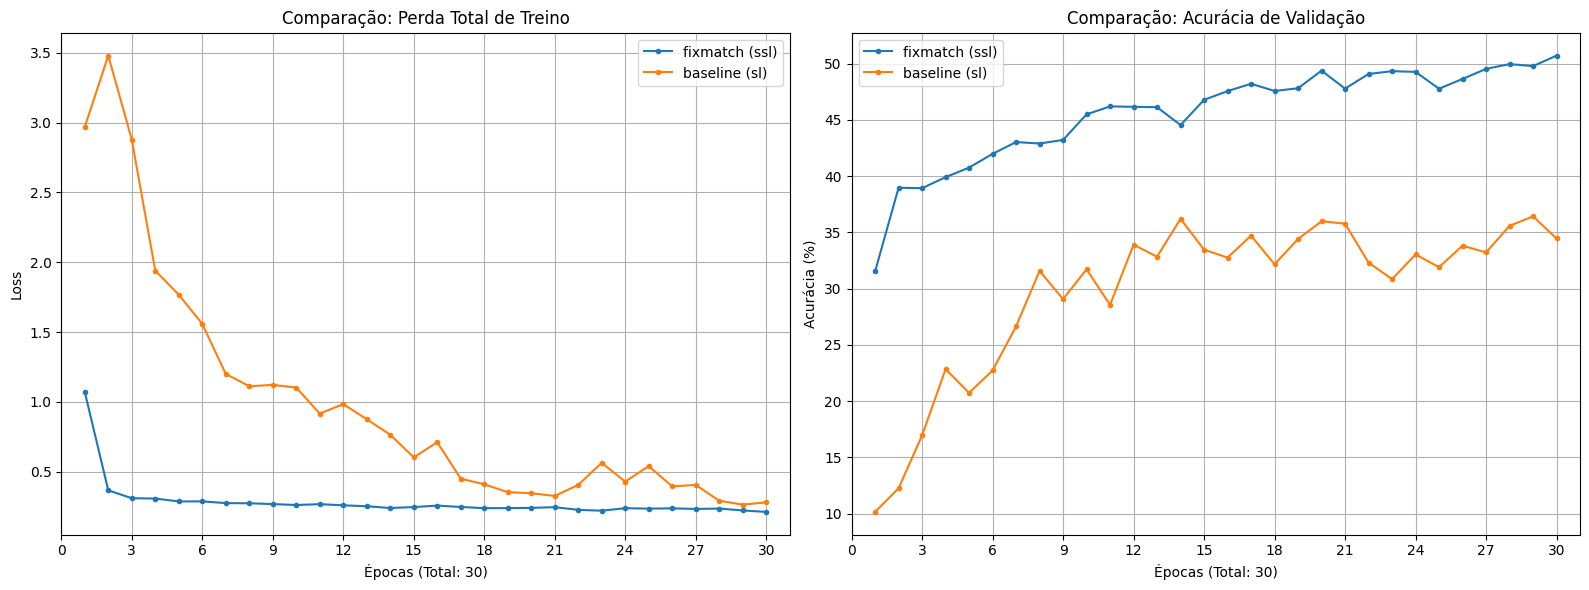

In [ ]:
# ==========================================
# PLOT 1 (SSL VS. SL)
# ==========================================

runs_ssl_vs_sl = {
    "fixmatch (ssl)": trainer.results_history["Run_25_Labels_30_Epochs"],
    "baseline (sl)": trainer_comparison.results_history["baseline_25_labels_sl"]
}

print("mostrando comparação: fixmatch (ssl) vs. baseline (sl)")
plot_histories(runs_ssl_vs_sl)

mostrando comparação: thresholds do fixmatch


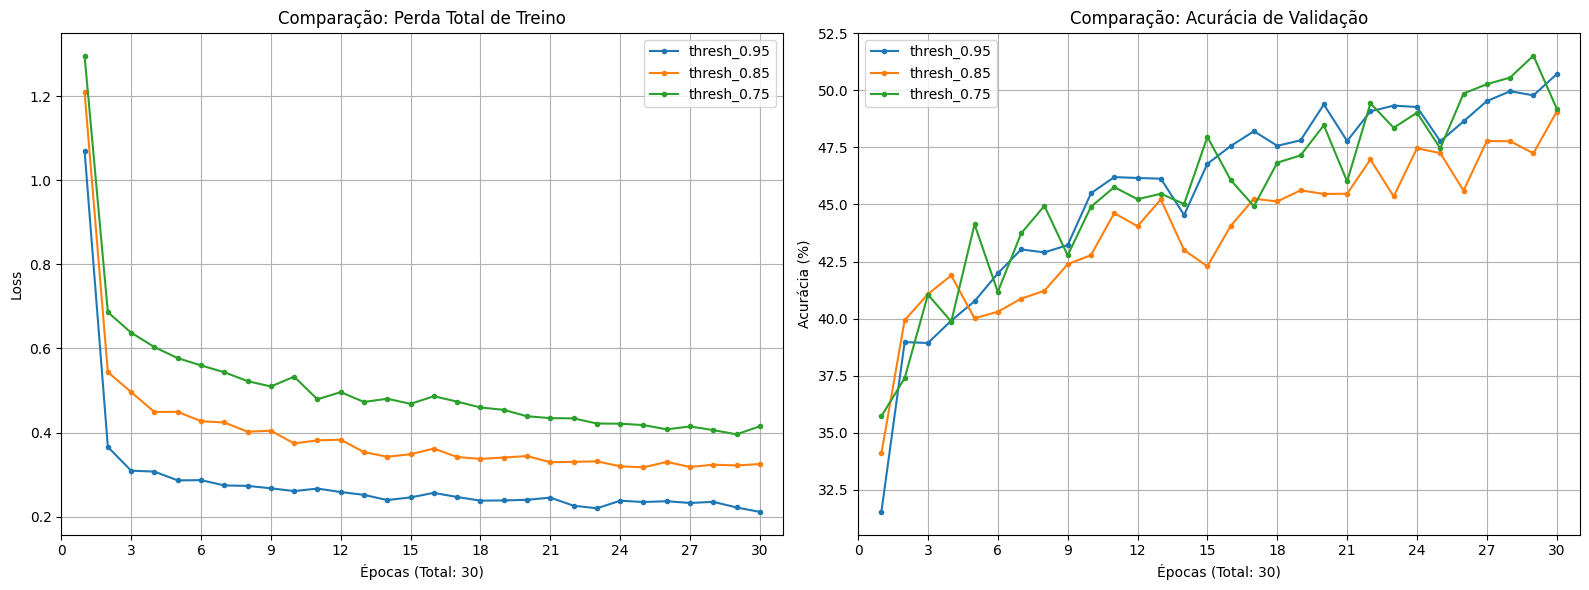

In [ ]:
runs_threshold = {
    "thresh_0.95": trainer.results_history["Run_25_Labels_30_Epochs"],
    "thresh_0.85": trainer_comparison.results_history["run_25_labels_thresh_0.85"],
    "thresh_0.75": trainer_comparison.results_history["run_25_labels_thresh_0.75"]
}

print("mostrando comparação: thresholds do fixmatch")
plot_histories(runs_threshold)

In [ ]:
# ==========================================
#    Função para carregar modelos treinados
# ==========================================

def carregar_e_visualizar(weights_path, test_loader, predictions_on_test=False, num_images=5):
    """
    Carrega os pesos de um modelo, opcionalmente visualiza suas previsões
    e retorna o modelo carregado.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_carregado = create_resnet18_cifar(num_classes=num_classes)

    try:
        state_dict = torch.load(weights_path, map_location=device)
    except Exception as e:
        print(f"Erro ao carregar pesos de '{weights_path}': {e}")
        return None

    model_carregado.load_state_dict(state_dict)
    model_carregado.to(device)
    model_carregado.eval()

    print(f"Modelo carregado com sucesso de '{weights_path}' (modo de avaliação).")

    if predictions_on_test:

        try:
            images_test, true_labels = next(iter(test_loader))
        except StopIteration:
            print("Reiniciando o data loader de teste...")
            test_loader = DataLoader(test_loader.dataset, batch_size=num_images, shuffle=True)
            images_test, true_labels = next(iter(test_loader))

        images_test = images_test.to(device)
        true_labels = true_labels.to(device)

        with torch.no_grad():
            logits = model_carregado(images_test)
            probs = torch.softmax(logits, dim=1)
            confidence, predicted_labels = torch.max(probs, dim=1)

        images_plot = images_test.cpu()
        predicted_labels = predicted_labels.cpu()
        true_labels = true_labels.cpu()
        confidence = confidence.cpu()

        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Previsões do modelo carregado ({num_images} imagens)", fontsize=16)

        for i in range(num_images):
            img_tensor = denormalize(images_plot[i])
            img_plot = img_tensor.permute(1, 2, 0)

            pred_name = classes[predicted_labels[i]]
            true_name = classes[true_labels[i]]
            conf_percent = confidence[i] * 100

            color = 'green' if pred_name == true_name else 'red'

            plt.subplot(1, num_images, i + 1)
            plt.imshow(img_plot)
            plt.title(f"Real: {true_name}\nPrevisto: {pred_name}\nConf: {conf_percent:.1f}%", color=color)
            plt.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    return model_carregado

In [ ]:
# ==========================================
#         EXECUÇÃO DO EXPERIMENTO
# ==========================================

print(f"\n===========================================================")
print(f"   INICIANDO TESTES com {400} RÓTULO(S) POR CLASSE   ")
print(f"===========================================================\n")

# Teste Baseline
baseline_run_name = f"baseline_{400}_labels_sl"
train_supervised_baseline(
    n_labels_per_class=400,
    num_epochs=N_EPOCHS,
    run_name=baseline_run_name
)

# Testes FixMatch 
for thresh in THRESHOLDS_PARA_TESTAR:

    fixmatch_run_name = f"fixmatch_{400}_labels_thresh_{thresh}"

    trainer_comparison.train(
        n_labels_per_class=400,
        num_epochs=N_EPOCHS,
        run_name=fixmatch_run_name,
        threshold=thresh,
        lambda_u=1.0 # Usando o padrão
    )

print("\n=========================================")
print("   TODOS OS EXPERIMENTOS CONCLUÍDOS   ")
print("=========================================\n")


   INICIANDO TESTES com 400 RÓTULO(S) POR CLASSE   

  labels por classe: 400, épocas: 30
  total de imagens rotuladas (baseline): 4000


época 1/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 21.45it/s, loss=2.21]


época 1 - val acc (baseline): 32.75%


época 2/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 23.57it/s, loss=1.69]


época 2 - val acc (baseline): 31.10%


época 3/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 24.44it/s, loss=1.56]


época 3 - val acc (baseline): 41.08%


época 4/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 21.80it/s, loss=1.43]


época 4 - val acc (baseline): 49.50%


época 5/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 24.12it/s, loss=1.34]


época 5 - val acc (baseline): 46.81%


época 6/30 (sl): 100%|██████████| 63/63 [00:03<00:00, 16.26it/s, loss=1.25]


época 6 - val acc (baseline): 50.86%


época 7/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 24.20it/s, loss=1.21]


época 7 - val acc (baseline): 56.33%


época 8/30 (sl): 100%|██████████| 63/63 [00:03<00:00, 19.54it/s, loss=1.15]


época 8 - val acc (baseline): 56.14%


época 9/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 23.66it/s, loss=1.07]


época 9 - val acc (baseline): 56.61%


época 10/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 24.08it/s, loss=1.02]


época 10 - val acc (baseline): 59.99%


época 11/30 (sl): 100%|██████████| 63/63 [00:03<00:00, 20.77it/s, loss=0.992]


época 11 - val acc (baseline): 55.72%


época 12/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 24.13it/s, loss=0.948]


época 12 - val acc (baseline): 58.30%


época 13/30 (sl): 100%|██████████| 63/63 [00:03<00:00, 18.55it/s, loss=0.868]


época 13 - val acc (baseline): 57.13%


época 14/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 24.44it/s, loss=0.837]


época 14 - val acc (baseline): 63.55%


época 15/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 21.17it/s, loss=0.827]


época 15 - val acc (baseline): 60.67%


época 16/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 24.22it/s, loss=0.779]


época 16 - val acc (baseline): 60.94%


época 17/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 23.60it/s, loss=0.754]


época 17 - val acc (baseline): 63.44%


época 18/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 22.34it/s, loss=0.735]


época 18 - val acc (baseline): 60.47%


época 19/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 23.43it/s, loss=0.7]


época 19 - val acc (baseline): 63.88%


época 20/30 (sl): 100%|██████████| 63/63 [00:03<00:00, 17.84it/s, loss=0.661]


época 20 - val acc (baseline): 63.76%


época 21/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 24.12it/s, loss=0.651]


época 21 - val acc (baseline): 64.36%


época 22/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 24.27it/s, loss=0.613]


época 22 - val acc (baseline): 58.88%


época 23/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 24.06it/s, loss=0.597]


época 23 - val acc (baseline): 62.86%


época 24/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 23.74it/s, loss=0.566]


época 24 - val acc (baseline): 59.50%


época 25/30 (sl): 100%|██████████| 63/63 [00:03<00:00, 18.44it/s, loss=0.533]


época 25 - val acc (baseline): 61.03%


época 26/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 23.28it/s, loss=0.542]


época 26 - val acc (baseline): 65.02%


época 27/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 21.44it/s, loss=0.52]


época 27 - val acc (baseline): 64.83%


época 28/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 23.13it/s, loss=0.473]


época 28 - val acc (baseline): 64.25%


época 29/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 23.91it/s, loss=0.491]


época 29 - val acc (baseline): 65.64%


época 30/30 (sl): 100%|██████████| 63/63 [00:02<00:00, 22.45it/s, loss=0.437]


época 30 - val acc (baseline): 67.05%
--- treino baseline 'baseline_400_labels_sl' concluído ---

--- Iniciando Treino: fixmatch_400_labels_thresh_0.99 ---
  Labels por classe: 400
  Total de Épocas: 30
  Total de imagens rotuladas: 4000
  Total de imagens não-rotuladas: 46000
  Batches rotulados/época: 32
  Batches não-rotulados/época: 51 (define a época)

Época 1/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.35s/it, Loss=1.92, Ls=1.92, Lu=0.000187]


Época 1 - Val Acc: 39.89% | Loss Total: 1.9176 (Ls: 1.9174, Lu: 0.0002)

Época 2/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.34s/it, Loss=1.46, Ls=1.46, Lu=0.000328]


Época 2 - Val Acc: 48.16% | Loss Total: 1.4615 (Ls: 1.4612, Lu: 0.0003)

Época 3/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.37s/it, Loss=1.28, Ls=1.28, Lu=0.00295]


Época 3 - Val Acc: 53.51% | Loss Total: 1.2810 (Ls: 1.2781, Lu: 0.0029)

Época 4/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.34s/it, Loss=1.15, Ls=1.15, Lu=0.00767]


Época 4 - Val Acc: 51.85% | Loss Total: 1.1549 (Ls: 1.1472, Lu: 0.0077)

Época 5/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.35s/it, Loss=1.05, Ls=1.03, Lu=0.0184]


Época 5 - Val Acc: 55.38% | Loss Total: 1.0482 (Ls: 1.0297, Lu: 0.0184)

Época 6/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.35s/it, Loss=0.966, Ls=0.94, Lu=0.0257]


Época 6 - Val Acc: 59.31% | Loss Total: 0.9658 (Ls: 0.9401, Lu: 0.0257)

Época 7/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=0.888, Ls=0.855, Lu=0.0336]


Época 7 - Val Acc: 57.43% | Loss Total: 0.8883 (Ls: 0.8547, Lu: 0.0336)

Época 8/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.35s/it, Loss=0.829, Ls=0.78, Lu=0.0488]


Época 8 - Val Acc: 58.72% | Loss Total: 0.8290 (Ls: 0.7802, Lu: 0.0488)

Época 9/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.35s/it, Loss=0.768, Ls=0.715, Lu=0.0532]


Época 9 - Val Acc: 59.99% | Loss Total: 0.7684 (Ls: 0.7152, Lu: 0.0532)

Época 10/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.39s/it, Loss=0.719, Ls=0.658, Lu=0.0608]


Época 10 - Val Acc: 61.77% | Loss Total: 0.7187 (Ls: 0.6579, Lu: 0.0608)

Época 11/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.38s/it, Loss=0.659, Ls=0.581, Lu=0.0779]


Época 11 - Val Acc: 62.23% | Loss Total: 0.6589 (Ls: 0.5810, Lu: 0.0779)

Época 12/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.37s/it, Loss=0.63, Ls=0.544, Lu=0.0864]


Época 12 - Val Acc: 63.08% | Loss Total: 0.6304 (Ls: 0.5440, Lu: 0.0864)

Época 13/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=0.609, Ls=0.516, Lu=0.0932]


Época 13 - Val Acc: 62.46% | Loss Total: 0.6093 (Ls: 0.5161, Lu: 0.0932)

Época 14/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=0.566, Ls=0.47, Lu=0.0967]


Época 14 - Val Acc: 60.61% | Loss Total: 0.5662 (Ls: 0.4696, Lu: 0.0967)

Época 15/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.37s/it, Loss=0.528, Ls=0.415, Lu=0.114]


Época 15 - Val Acc: 65.19% | Loss Total: 0.5285 (Ls: 0.4146, Lu: 0.1138)

Época 16/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.35s/it, Loss=0.496, Ls=0.366, Lu=0.13]


Época 16 - Val Acc: 63.90% | Loss Total: 0.4958 (Ls: 0.3656, Lu: 0.1302)

Época 17/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.37s/it, Loss=0.476, Ls=0.353, Lu=0.123]


Época 17 - Val Acc: 65.20% | Loss Total: 0.4765 (Ls: 0.3533, Lu: 0.1232)

Época 18/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=0.483, Ls=0.345, Lu=0.138]


Época 18 - Val Acc: 64.13% | Loss Total: 0.4827 (Ls: 0.3450, Lu: 0.1377)

Época 19/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=0.434, Ls=0.299, Lu=0.136]


Época 19 - Val Acc: 66.86% | Loss Total: 0.4345 (Ls: 0.2987, Lu: 0.1358)

Época 20/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.37s/it, Loss=0.406, Ls=0.258, Lu=0.148]


Época 20 - Val Acc: 67.27% | Loss Total: 0.4062 (Ls: 0.2580, Lu: 0.1481)

Época 21/30


Epoch Treino: 100%|██████████| 51/51 [01:13<00:00,  1.45s/it, Loss=0.403, Ls=0.257, Lu=0.147]


Época 21 - Val Acc: 66.42% | Loss Total: 0.4032 (Ls: 0.2566, Lu: 0.1466)

Época 22/30


Epoch Treino: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it, Loss=0.389, Ls=0.227, Lu=0.161]


Época 22 - Val Acc: 67.56% | Loss Total: 0.3888 (Ls: 0.2273, Lu: 0.1615)

Época 23/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.37s/it, Loss=0.412, Ls=0.259, Lu=0.153]


Época 23 - Val Acc: 65.57% | Loss Total: 0.4117 (Ls: 0.2589, Lu: 0.1528)

Época 24/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.39s/it, Loss=0.362, Ls=0.211, Lu=0.151]


Época 24 - Val Acc: 66.69% | Loss Total: 0.3622 (Ls: 0.2113, Lu: 0.1510)

Época 25/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.34s/it, Loss=0.353, Ls=0.193, Lu=0.16]


Época 25 - Val Acc: 66.35% | Loss Total: 0.3534 (Ls: 0.1931, Lu: 0.1603)

Época 26/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.34s/it, Loss=0.356, Ls=0.192, Lu=0.163]


Época 26 - Val Acc: 68.29% | Loss Total: 0.3555 (Ls: 0.1924, Lu: 0.1632)

Época 27/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=0.326, Ls=0.163, Lu=0.162]


Época 27 - Val Acc: 68.86% | Loss Total: 0.3257 (Ls: 0.1634, Lu: 0.1623)

Época 28/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=0.318, Ls=0.146, Lu=0.172]


Época 28 - Val Acc: 67.94% | Loss Total: 0.3182 (Ls: 0.1463, Lu: 0.1719)

Época 29/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.38s/it, Loss=0.29, Ls=0.111, Lu=0.18]


Época 29 - Val Acc: 69.77% | Loss Total: 0.2903 (Ls: 0.1107, Lu: 0.1796)

Época 30/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.35s/it, Loss=0.286, Ls=0.11, Lu=0.176]


Época 30 - Val Acc: 69.84% | Loss Total: 0.2859 (Ls: 0.1104, Lu: 0.1755)
--- Treino 'fixmatch_400_labels_thresh_0.99' Concluído ---

--- Iniciando Treino: fixmatch_400_labels_thresh_0.95 ---
  Labels por classe: 400
  Total de Épocas: 30
  Total de imagens rotuladas: 4000
  Total de imagens não-rotuladas: 46000
  Batches rotulados/época: 32
  Batches não-rotulados/época: 51 (define a época)

Época 1/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=1.92, Ls=1.92, Lu=0.00361]


Época 1 - Val Acc: 42.38% | Loss Total: 1.9215 (Ls: 1.9179, Lu: 0.0036)

Época 2/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.38s/it, Loss=1.45, Ls=1.44, Lu=0.0105]


Época 2 - Val Acc: 47.12% | Loss Total: 1.4494 (Ls: 1.4389, Lu: 0.0105)

Época 3/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.37s/it, Loss=1.28, Ls=1.25, Lu=0.0319]


Época 3 - Val Acc: 55.92% | Loss Total: 1.2828 (Ls: 1.2508, Lu: 0.0319)

Época 4/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.39s/it, Loss=1.17, Ls=1.12, Lu=0.0551]


Época 4 - Val Acc: 56.42% | Loss Total: 1.1711 (Ls: 1.1160, Lu: 0.0551)

Época 5/30


Epoch Treino: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it, Loss=1.07, Ls=1, Lu=0.073]


Época 5 - Val Acc: 58.30% | Loss Total: 1.0741 (Ls: 1.0010, Lu: 0.0730)

Época 6/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.39s/it, Loss=0.965, Ls=0.872, Lu=0.0932]


Época 6 - Val Acc: 58.52% | Loss Total: 0.9653 (Ls: 0.8720, Lu: 0.0932)

Época 7/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.38s/it, Loss=0.933, Ls=0.827, Lu=0.106]


Época 7 - Val Acc: 62.31% | Loss Total: 0.9331 (Ls: 0.8266, Lu: 0.1065)

Época 8/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.38s/it, Loss=0.871, Ls=0.752, Lu=0.12]


Época 8 - Val Acc: 60.42% | Loss Total: 0.8712 (Ls: 0.7517, Lu: 0.1195)

Época 9/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=0.811, Ls=0.677, Lu=0.134]


Época 9 - Val Acc: 60.63% | Loss Total: 0.8112 (Ls: 0.6771, Lu: 0.1341)

Época 10/30


Epoch Treino: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it, Loss=0.779, Ls=0.629, Lu=0.15]


Época 10 - Val Acc: 62.47% | Loss Total: 0.7791 (Ls: 0.6293, Lu: 0.1498)

Época 11/30


Epoch Treino: 100%|██████████| 51/51 [01:12<00:00,  1.41s/it, Loss=0.743, Ls=0.58, Lu=0.163]


Época 11 - Val Acc: 62.88% | Loss Total: 0.7435 (Ls: 0.5800, Lu: 0.1635)

Época 12/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.38s/it, Loss=0.702, Ls=0.521, Lu=0.181]


Época 12 - Val Acc: 63.61% | Loss Total: 0.7021 (Ls: 0.5215, Lu: 0.1806)

Época 13/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.37s/it, Loss=0.659, Ls=0.474, Lu=0.185]


Época 13 - Val Acc: 64.60% | Loss Total: 0.6592 (Ls: 0.4741, Lu: 0.1851)

Época 14/30


Epoch Treino: 100%|██████████| 51/51 [01:12<00:00,  1.41s/it, Loss=0.641, Ls=0.437, Lu=0.204]


Época 14 - Val Acc: 63.18% | Loss Total: 0.6408 (Ls: 0.4373, Lu: 0.2036)

Época 15/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.38s/it, Loss=0.606, Ls=0.397, Lu=0.209]


Época 15 - Val Acc: 64.94% | Loss Total: 0.6065 (Ls: 0.3972, Lu: 0.2093)

Época 16/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=0.569, Ls=0.347, Lu=0.222]


Época 16 - Val Acc: 67.08% | Loss Total: 0.5694 (Ls: 0.3472, Lu: 0.2222)

Época 17/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.38s/it, Loss=0.549, Ls=0.317, Lu=0.232]


Época 17 - Val Acc: 66.30% | Loss Total: 0.5494 (Ls: 0.3171, Lu: 0.2323)

Época 18/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.38s/it, Loss=0.542, Ls=0.303, Lu=0.239]


Época 18 - Val Acc: 67.20% | Loss Total: 0.5424 (Ls: 0.3032, Lu: 0.2391)

Época 19/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.37s/it, Loss=0.532, Ls=0.29, Lu=0.242]


Época 19 - Val Acc: 66.64% | Loss Total: 0.5319 (Ls: 0.2899, Lu: 0.2421)

Época 20/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.39s/it, Loss=0.48, Ls=0.227, Lu=0.253]


Época 20 - Val Acc: 67.82% | Loss Total: 0.4798 (Ls: 0.2269, Lu: 0.2530)

Época 21/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.37s/it, Loss=0.478, Ls=0.222, Lu=0.256]


Época 21 - Val Acc: 67.68% | Loss Total: 0.4780 (Ls: 0.2220, Lu: 0.2560)

Época 22/30


Epoch Treino: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it, Loss=0.459, Ls=0.199, Lu=0.26]


Época 22 - Val Acc: 69.55% | Loss Total: 0.4591 (Ls: 0.1995, Lu: 0.2596)

Época 23/30


Epoch Treino: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it, Loss=0.453, Ls=0.197, Lu=0.256]


Época 23 - Val Acc: 67.84% | Loss Total: 0.4528 (Ls: 0.1967, Lu: 0.2562)

Época 24/30


Epoch Treino: 100%|██████████| 51/51 [01:11<00:00,  1.39s/it, Loss=0.445, Ls=0.177, Lu=0.268]


Época 24 - Val Acc: 69.97% | Loss Total: 0.4447 (Ls: 0.1766, Lu: 0.2681)

Época 25/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.38s/it, Loss=0.436, Ls=0.166, Lu=0.269]


Época 25 - Val Acc: 71.41% | Loss Total: 0.4356 (Ls: 0.1664, Lu: 0.2692)

Época 26/30


Epoch Treino: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it, Loss=0.41, Ls=0.135, Lu=0.276]


Época 26 - Val Acc: 69.48% | Loss Total: 0.4104 (Ls: 0.1347, Lu: 0.2757)

Época 27/30


Epoch Treino: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it, Loss=0.431, Ls=0.161, Lu=0.27]


Época 27 - Val Acc: 70.72% | Loss Total: 0.4310 (Ls: 0.1609, Lu: 0.2701)

Época 28/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.37s/it, Loss=0.434, Ls=0.169, Lu=0.264]


Época 28 - Val Acc: 69.93% | Loss Total: 0.4338 (Ls: 0.1694, Lu: 0.2644)

Época 29/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.39s/it, Loss=0.387, Ls=0.129, Lu=0.258]


Época 29 - Val Acc: 72.16% | Loss Total: 0.3873 (Ls: 0.1292, Lu: 0.2580)

Época 30/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.38s/it, Loss=0.385, Ls=0.104, Lu=0.282]


Época 30 - Val Acc: 72.68% | Loss Total: 0.3854 (Ls: 0.1037, Lu: 0.2817)
--- Treino 'fixmatch_400_labels_thresh_0.95' Concluído ---

--- Iniciando Treino: fixmatch_400_labels_thresh_0.8 ---
  Labels por classe: 400
  Total de Épocas: 30
  Total de imagens rotuladas: 4000
  Total de imagens não-rotuladas: 46000
  Batches rotulados/época: 32
  Batches não-rotulados/época: 51 (define a época)

Época 1/30


Epoch Treino: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it, Loss=1.93, Ls=1.9, Lu=0.0296]


Época 1 - Val Acc: 37.48% | Loss Total: 1.9345 (Ls: 1.9049, Lu: 0.0296)

Época 2/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.37s/it, Loss=1.52, Ls=1.44, Lu=0.0877]


Época 2 - Val Acc: 48.09% | Loss Total: 1.5231 (Ls: 1.4354, Lu: 0.0877)

Época 3/30


Epoch Treino: 100%|██████████| 51/51 [01:11<00:00,  1.39s/it, Loss=1.4, Ls=1.26, Lu=0.146]


Época 3 - Val Acc: 52.85% | Loss Total: 1.4039 (Ls: 1.2578, Lu: 0.1461)

Época 4/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=1.31, Ls=1.13, Lu=0.184]


Época 4 - Val Acc: 54.19% | Loss Total: 1.3100 (Ls: 1.1264, Lu: 0.1836)

Época 5/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.39s/it, Loss=1.25, Ls=1.03, Lu=0.225]


Época 5 - Val Acc: 57.95% | Loss Total: 1.2510 (Ls: 1.0265, Lu: 0.2246)

Época 6/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.38s/it, Loss=1.17, Ls=0.91, Lu=0.256]


Época 6 - Val Acc: 59.29% | Loss Total: 1.1653 (Ls: 0.9098, Lu: 0.2555)

Época 7/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.37s/it, Loss=1.09, Ls=0.817, Lu=0.276]


Época 7 - Val Acc: 60.39% | Loss Total: 1.0930 (Ls: 0.8167, Lu: 0.2763)

Época 8/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.37s/it, Loss=1.04, Ls=0.728, Lu=0.313]


Época 8 - Val Acc: 59.93% | Loss Total: 1.0409 (Ls: 0.7278, Lu: 0.3132)

Época 9/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=0.975, Ls=0.648, Lu=0.327]


Época 9 - Val Acc: 62.02% | Loss Total: 0.9752 (Ls: 0.6480, Lu: 0.3272)

Época 10/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.39s/it, Loss=0.961, Ls=0.6, Lu=0.362]


Época 10 - Val Acc: 61.59% | Loss Total: 0.9614 (Ls: 0.5999, Lu: 0.3615)

Época 11/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.35s/it, Loss=0.904, Ls=0.531, Lu=0.373]


Época 11 - Val Acc: 64.70% | Loss Total: 0.9035 (Ls: 0.5310, Lu: 0.3725)

Época 12/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=0.875, Ls=0.489, Lu=0.386]


Época 12 - Val Acc: 64.88% | Loss Total: 0.8750 (Ls: 0.4889, Lu: 0.3861)

Época 13/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=0.818, Ls=0.434, Lu=0.384]


Época 13 - Val Acc: 64.07% | Loss Total: 0.8182 (Ls: 0.4338, Lu: 0.3843)

Época 14/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.35s/it, Loss=0.794, Ls=0.393, Lu=0.401]


Época 14 - Val Acc: 66.68% | Loss Total: 0.7937 (Ls: 0.3930, Lu: 0.4006)

Época 15/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.35s/it, Loss=0.739, Ls=0.33, Lu=0.409]


Época 15 - Val Acc: 64.74% | Loss Total: 0.7391 (Ls: 0.3298, Lu: 0.4093)

Época 16/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.34s/it, Loss=0.745, Ls=0.332, Lu=0.413]


Época 16 - Val Acc: 65.55% | Loss Total: 0.7448 (Ls: 0.3315, Lu: 0.4133)

Época 17/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=0.732, Ls=0.303, Lu=0.429]


Época 17 - Val Acc: 67.09% | Loss Total: 0.7317 (Ls: 0.3026, Lu: 0.4291)

Época 18/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.34s/it, Loss=0.678, Ls=0.254, Lu=0.424]


Época 18 - Val Acc: 68.59% | Loss Total: 0.6781 (Ls: 0.2541, Lu: 0.4240)

Época 19/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.35s/it, Loss=0.667, Ls=0.232, Lu=0.435]


Época 19 - Val Acc: 69.59% | Loss Total: 0.6675 (Ls: 0.2320, Lu: 0.4355)

Época 20/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.34s/it, Loss=0.67, Ls=0.223, Lu=0.446]


Época 20 - Val Acc: 68.33% | Loss Total: 0.6696 (Ls: 0.2232, Lu: 0.4464)

Época 21/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.35s/it, Loss=0.65, Ls=0.209, Lu=0.441]


Época 21 - Val Acc: 68.25% | Loss Total: 0.6498 (Ls: 0.2090, Lu: 0.4408)

Época 22/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.34s/it, Loss=0.627, Ls=0.184, Lu=0.443]


Época 22 - Val Acc: 70.78% | Loss Total: 0.6269 (Ls: 0.1839, Lu: 0.4430)

Época 23/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.34s/it, Loss=0.606, Ls=0.159, Lu=0.447]


Época 23 - Val Acc: 69.53% | Loss Total: 0.6057 (Ls: 0.1587, Lu: 0.4470)

Época 24/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=0.594, Ls=0.149, Lu=0.444]


Época 24 - Val Acc: 68.92% | Loss Total: 0.5940 (Ls: 0.1495, Lu: 0.4445)

Época 25/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=0.584, Ls=0.145, Lu=0.439]


Época 25 - Val Acc: 70.73% | Loss Total: 0.5842 (Ls: 0.1455, Lu: 0.4387)

Época 26/30


Epoch Treino: 100%|██████████| 51/51 [01:10<00:00,  1.37s/it, Loss=0.586, Ls=0.142, Lu=0.444]


Época 26 - Val Acc: 71.46% | Loss Total: 0.5858 (Ls: 0.1419, Lu: 0.4438)

Época 27/30


Epoch Treino: 100%|██████████| 51/51 [01:08<00:00,  1.34s/it, Loss=0.563, Ls=0.122, Lu=0.441]


Época 27 - Val Acc: 71.42% | Loss Total: 0.5628 (Ls: 0.1221, Lu: 0.4407)

Época 28/30


Epoch Treino: 100%|██████████| 51/51 [01:07<00:00,  1.33s/it, Loss=0.572, Ls=0.133, Lu=0.439]


Época 28 - Val Acc: 70.77% | Loss Total: 0.5720 (Ls: 0.1333, Lu: 0.4387)

Época 29/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=0.545, Ls=0.111, Lu=0.434]


Época 29 - Val Acc: 72.05% | Loss Total: 0.5454 (Ls: 0.1113, Lu: 0.4340)

Época 30/30


Epoch Treino: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it, Loss=0.54, Ls=0.106, Lu=0.434]


Época 30 - Val Acc: 72.86% | Loss Total: 0.5402 (Ls: 0.1060, Lu: 0.4343)
--- Treino 'fixmatch_400_labels_thresh_0.8' Concluído ---

   TODOS OS EXPERIMENTOS CONCLUÍDOS   

Plotando comparação para 400 RÓTULOS:


KeyError: 'fixmatch_400_labels_thresh_0.80'

Plotando comparação para 400 RÓTULOS:


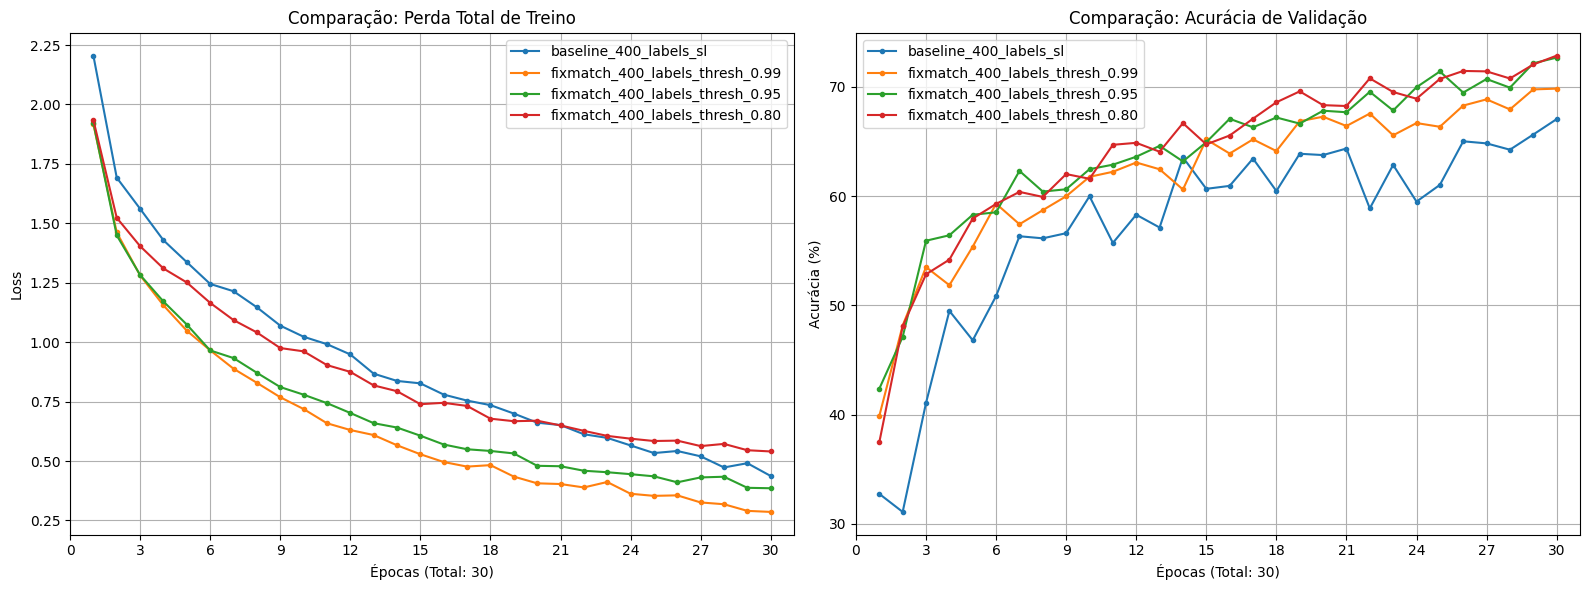

In [27]:
print("Plotando comparação para 400 RÓTULOS:")

runs_para_comparar_400 = {
    "baseline_400_labels_sl": trainer_comparison.results_history["baseline_400_labels_sl"],
    "fixmatch_400_labels_thresh_0.99": trainer_comparison.results_history["fixmatch_400_labels_thresh_0.99"],
    "fixmatch_400_labels_thresh_0.95": trainer_comparison.results_history["fixmatch_400_labels_thresh_0.95"],
    "fixmatch_400_labels_thresh_0.80": trainer_comparison.results_history["fixmatch_400_labels_thresh_0.8"]
}
plot_histories(runs_para_comparar_400)

## Experimento adiconal

Modelo carregado com sucesso de 'Run_400_Labels_30_Epochs_best_model.pth'.
Iniciando análise de confiança em 50000 imagens...


Analisando lotes: 100%|██████████| 196/196 [00:24<00:00,  7.99it/s]



--- Análise de Confiança Concluída ---
  Confiança média:    0.8713
  Confiança mediana:  0.9717
  Percentil 75º:      0.9989
  Percentil 90º:      1.0000
  Percentil 95º:      1.0000 (o paper usa este)


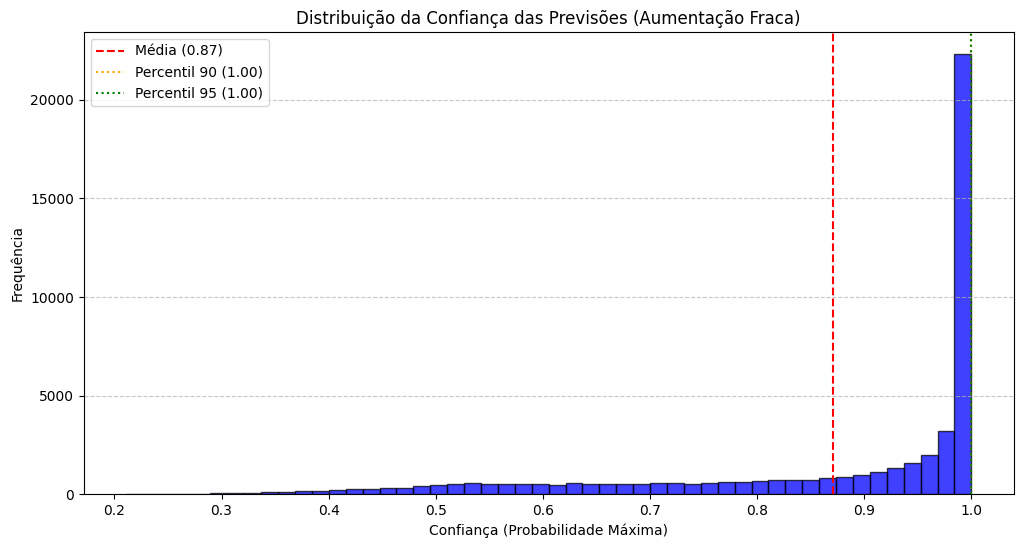

Modelo carregado com sucesso de 'Run_25_Labels_30_Epochs_best_model.pth'.
Iniciando análise de confiança em 50000 imagens...


Analisando lotes: 100%|██████████| 196/196 [00:27<00:00,  7.00it/s]



--- Análise de Confiança Concluída ---
  Confiança média:    0.8587
  Confiança mediana:  0.9608
  Percentil 75º:      0.9983
  Percentil 90º:      0.9999
  Percentil 95º:      1.0000 (o paper usa este)


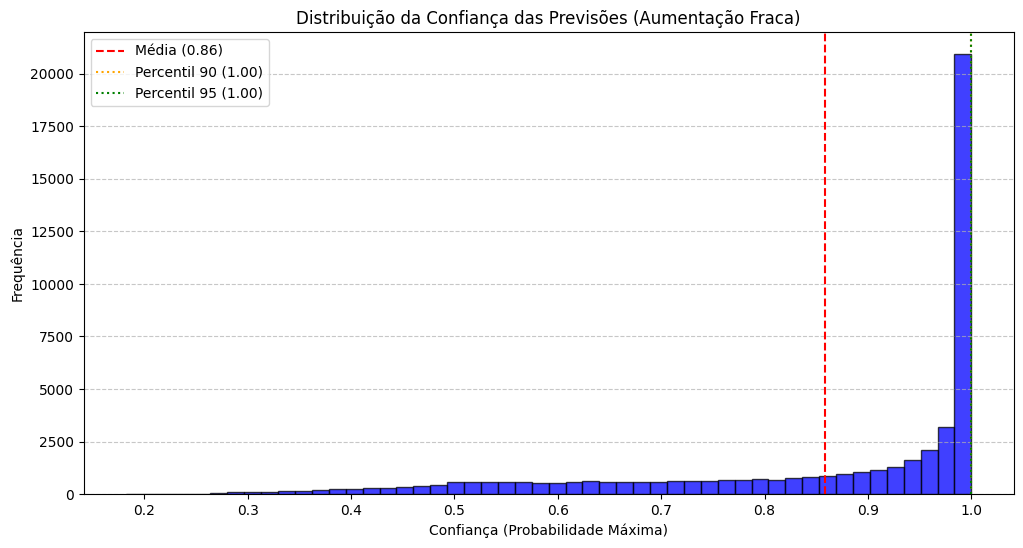

Modelo carregado com sucesso de 'Run_4_Labels_30_Epochs_best_model.pth'.
Iniciando análise de confiança em 50000 imagens...


Analisando lotes: 100%|██████████| 196/196 [00:25<00:00,  7.68it/s]



--- Análise de Confiança Concluída ---
  Confiança média:    0.8541
  Confiança mediana:  0.9538
  Percentil 75º:      0.9976
  Percentil 90º:      0.9999
  Percentil 95º:      1.0000 (o paper usa este)


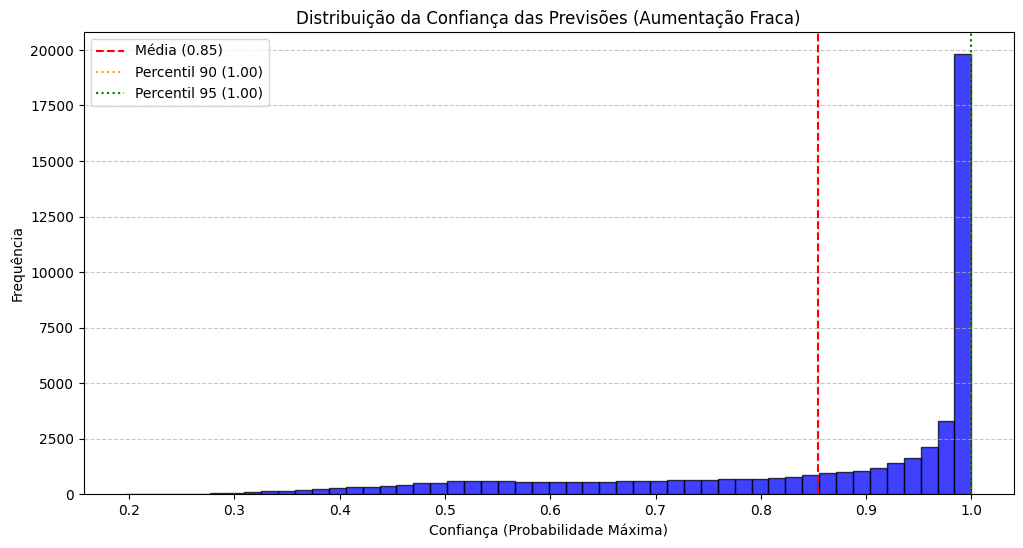

Modelo carregado com sucesso de 'Run_1_Labels_30_Epochs_best_model.pth'.
Iniciando análise de confiança em 50000 imagens...


Analisando lotes: 100%|██████████| 196/196 [00:25<00:00,  7.72it/s]



--- Análise de Confiança Concluída ---
  Confiança média:    0.7778
  Confiança mediana:  0.8609
  Percentil 75º:      0.9890
  Percentil 90º:      0.9995
  Percentil 95º:      0.9999 (o paper usa este)


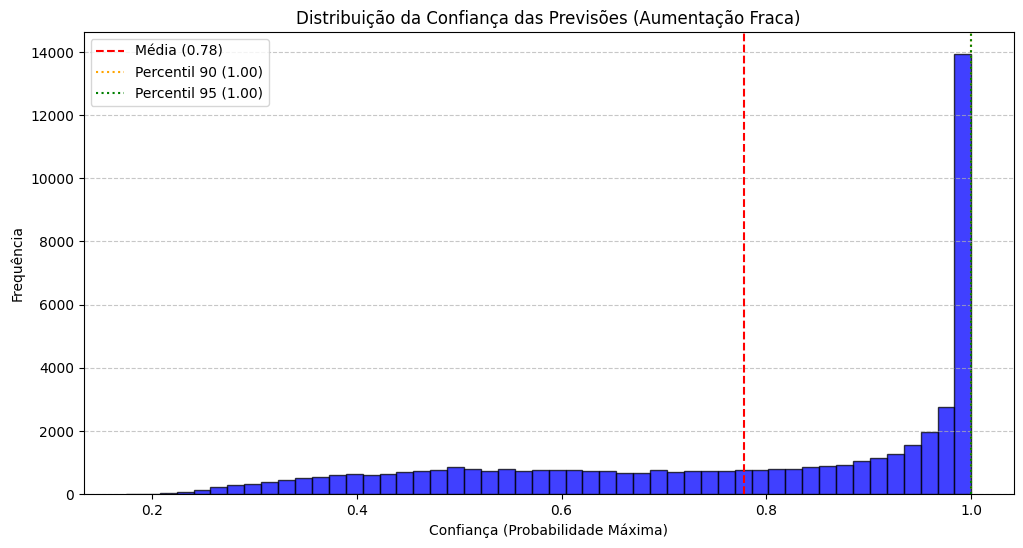

In [ ]:
def analisar_confianca_modelo(weights_path, dataset_para_analise, transform):
    """
    Carrega os pesos de um modelo (baseado na sua função) e analisa
    a distribuição de confiança das previsões em um dataset inteiro.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_carregado = create_resnet18_cifar(num_classes=num_classes)

    try:
        state_dict = torch.load(weights_path, map_location=device)
    except Exception as e:
        print(f"Erro ao carregar pesos de '{weights_path}': {e}")
        return None

    model_carregado.load_state_dict(state_dict)
    model_carregado.to(device)
    model_carregado.eval()
    print(f"Modelo carregado com sucesso de '{weights_path}'.")

    dataset_transformado = LabeledDatasetWrapper(dataset_para_analise, transform)
    data_loader = DataLoader(dataset_transformado, batch_size=256, shuffle=False, num_workers=2)

    all_confidences = []

    print(f"Iniciando análise de confiança em {len(dataset_para_analise)} imagens...")

    with torch.no_grad():
        for inputs, _ in tqdm(data_loader, desc="Analisando lotes"):
            inputs = inputs.to(device)

            logits = model_carregado(inputs)
            probs = torch.softmax(logits, dim=1)
            max_probs, _ = torch.max(probs, dim=1)

            all_confidences.append(max_probs.cpu())

    all_confidences = torch.cat(all_confidences)

    # métricas
    mean_conf = all_confidences.mean().item()
    median_conf = all_confidences.median().item()
    pct_95 = torch.quantile(all_confidences, 0.95).item()
    pct_90 = torch.quantile(all_confidences, 0.90).item()
    pct_75 = torch.quantile(all_confidences, 0.75).item()

    print("\n--- Análise de Confiança Concluída ---")
    print(f"  Confiança média:    {mean_conf:.4f}")
    print(f"  Confiança mediana:  {median_conf:.4f}")
    print(f"  Percentil 75º:      {pct_75:.4f}")
    print(f"  Percentil 90º:      {pct_90:.4f}")
    print(f"  Percentil 95º:      {pct_95:.4f} (o paper usa este)")

    plt.figure(figsize=(12, 6))
    plt.hist(all_confidences.numpy(), bins=50, alpha=0.75, color='blue', edgecolor='black')
    plt.title('Distribuição da Confiança das Previsões (Aumentação Fraca)')
    plt.xlabel('Confiança (Probabilidade Máxima)')
    plt.ylabel('Frequência')

    # linhas de percentil
    plt.axvline(mean_conf, color='red', linestyle='--', label=f'Média ({mean_conf:.2f})')
    plt.axvline(pct_90, color='orange', linestyle=':', label=f'Percentil 90 ({pct_90:.2f})')
    plt.axvline(pct_95, color='green', linestyle=':', label=f'Percentil 95 ({pct_95:.2f})')

    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return model_carregado, all_confidences


path_pesos_400 = "Run_400_Labels_30_Epochs_best_model.pth"
path_pesos_25 = "Run_25_Labels_30_Epochs_best_model.pth"
path_pesos_4 = "Run_4_Labels_30_Epochs_best_model.pth"
path_pesos_1 = "Run_1_Labels_30_Epochs_best_model.pth"

modelo_analisado, confiancas = analisar_confianca_modelo(
    weights_path=path_pesos_400,
    dataset_para_analise=raw_train_dataset,
    transform=transform_weak
)
modelo_analisado, confiancas = analisar_confianca_modelo(
    weights_path=path_pesos_25,
    dataset_para_analise=raw_train_dataset,
    transform=transform_weak
)
modelo_analisado, confiancas = analisar_confianca_modelo(
    weights_path=path_pesos_4,
    dataset_para_analise=raw_train_dataset,
    transform=transform_weak
)
modelo_analisado, confiancas = analisar_confianca_modelo(
    weights_path=path_pesos_1,
    dataset_para_analise=raw_train_dataset,
    transform=transform_weak
)